<a href="https://colab.research.google.com/github/spuportfolio2025/Project/blob/main/pairs_trading_investment_strategy_report_GROUP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stratified Data Download

In [ ]:
import pandas as pd
import requests
from datetime import date, timedelta
import yfinance as yf
import numpy as np

WIKI_URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
UA = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/122 Safari/537.36"
    )
}

html = requests.get(WIKI_URL, headers=UA, timeout=20).text

# Read ALL tables
tables = pd.read_html(html)

# --- Find the S&P 500 constituents table robustly ---
def has_symbol_column(tbl):
    cols = tbl.columns
    # Handle both normal Index and MultiIndex
    if isinstance(cols, pd.MultiIndex):
        level0 = [c[0] for c in cols]
        return "Symbol" in level0
    else:
        return "Symbol" in cols

constituents = None
for t in tables:
    if has_symbol_column(t):
        constituents = t
        break

if constituents is None:
    raise RuntimeError("Could not find constituents table with a 'Symbol' column.")

df = constituents.copy()

# --- Flatten MultiIndex columns if needed ---
if isinstance(df.columns, pd.MultiIndex):
    # Use the first level (which contains 'Symbol', 'Security', etc.)
    df.columns = [c[0] for c in df.columns]

# Now we know we have 'Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry'
df = df.rename(columns={
    "Symbol": "ticker",
    "Security": "name",
    "GICS Sector": "GICS Sector",
    "GICS Sub-Industry": "GICS Sub-Industry",
})

# This will now work because 'ticker' exists
df["ticker"] = df["ticker"].str.replace(".", "-", regex=False)

sp500, has_gics = df[["ticker", "name", "GICS Sector", "GICS Sub-Industry"]].drop_duplicates(), True

def choose_tickers_by_industry(df, by_field="GICS Sector", n=10, random_state=42):
    return (
        df.groupby(by_field, group_keys=False)
          .apply(lambda x: x.sample(n=min(len(x), n), random_state=random_state))
          .reset_index(drop=True)
    )

tickers = choose_tickers_by_industry(sp500)
print(f"Selected {len(tickers)} stocks in total")

tickers_arr = tickers.ticker.unique()
tickers_list = tickers_arr.tolist()
end = date(2025, 11, 13)
start = end - timedelta(days=365 * 10)

all_parts = []

data = yf.download(
    tickers_list,
    start=start.strftime("%Y-%m-%d"),
    end=end.strftime("%Y-%m-%d"),
    interval="1d",
    group_by="ticker",
    auto_adjust=False,
    threads=True,
    progress=False
)
if "Open" in data.columns.get_level_values(0):
    data = data.swaplevel(0, 1, axis=1)
data = data.stack(level=0).reset_index().rename(columns={"level_1": "ticker"})

all_parts.append(data)
ohlcv = pd.concat(all_parts, ignore_index=True)

ohlcv = ohlcv.rename(columns={
    "Date": "date",
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Adj Close": "adj_close",
    "Volume": "volume"
})[["date","Ticker","open","high","low","close","adj_close","volume"]]
ohlcv = ohlcv.sort_values(["Ticker","date"]).reset_index(drop=True)
ohlcv = ohlcv.merge(tickers, left_on = 'Ticker', right_on = 'ticker', how = 'left').drop(['ticker'], axis = 1)

C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\2055897526.py:19: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)
C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\2055897526.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), n), random_state=random_state))


Selected 110 stocks in total


C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\2055897526.py:89: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0).reset_index().rename(columns={"level_1": "ticker"})


In [ ]:
ohlcv = pd.read_excel("ohlcv_data.xlsx", sheet_name = 'Sheet1')

## Cointegration Method

### 1 - Fixed Window + Covid period tested to see performance return of co-integration

Tickers with >=5 years of data: 106
       p_level p_diff I_1_flag
ABT   0.693345    0.0     True
ACN   0.445207    0.0     True
ADP   0.635345    0.0     True
ADSK  0.493324    0.0     True
AES   0.274669    0.0     True
...        ...    ...      ...
VZ    0.430084    0.0     True
WEC   0.446843    0.0     True
WELL  0.998132    0.0     True
WST   0.525408    0.0     True
WYNN  0.084354    0.0     True

[106 rows x 3 columns]
I(1) tickers: ['ABT', 'ACN', 'ADP', 'ADSK', 'AES', 'AFL', 'ALB', 'AMP', 'APA', 'APD', 'APH', 'ARE', 'BAC', 'BAX', 'BKR', 'BLK', 'CARR', 'CDNS', 'CF', 'CLX', 'CNC', 'COP', 'COR', 'CPB', 'CRM', 'CTAS', 'DAL', 'DD', 'DDOG', 'DLR', 'DLTR', 'DUK', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EG', 'EMR', 'EQIX', 'EQT', 'EVRG', 'EXC', 'EXR', 'FICO', 'GD', 'GE', 'GL', 'GM', 'GNRC', 'GOOG', 'GOOGL', 'HAL', 'HAS', 'HRL', 'HSY', 'IFF', 'IPG', 'IQV', 'IRM', 'JBL', 'LIN', 'LLY', 'LOW', 'LULU', 'LW', 'LYV', 'MAR', 'META', 'MKC', 'MMM', 'MOS', 'MPC', 'NKE', 'NWSA', 'NXPI', 'OKE', 'PEP',

C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\3579198801.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = result.params[0]
C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\3579198801.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta  = result.params[1]
C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\3579198801.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = result.params[0]
C:\Users\zhyim\A

        X     Y   p_value     alpha      beta
9     ABT   LYV  0.000032  1.487274  0.694416
403   IPG  STLD  0.000086  2.619403  0.136241
365    GE   RJF  0.000255 -4.636132  2.127010
359  FICO   LIN  0.000265 -6.462464  2.320120
327    ED  SBAC  0.000269  2.575178  0.349035
..    ...   ...       ...       ...       ...
127   ARE   PEP  0.049565  0.654557  0.889161
200   CRM  GNRC  0.049578  3.762105  0.295392
168    CF   OKE  0.049659  1.246919  0.608750
31    ADP    ED  0.049829 -1.529090  1.477560
302   DUK   HRL  0.049884  2.071055  0.642798

[493 rows x 5 columns]
TOP STRATEGIES (Last 6 months with 3σ Stop-Loss):


C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\3579198801.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = result.params[0]
C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\3579198801.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta  = result.params[1]
C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\3579198801.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = result.params[0]
C:\Users\zhyim\A

,pair,Sharpe,TotalReturn,LastEquity
6,ACN-EQIX,2.708636,0.367999,1.367999
5,ARE-LIN,2.069439,0.417420,1.417420
1,IPG-STLD,1.992294,0.213909,1.213909
7,EVRG-WST,1.855572,0.208593,1.208593
16,CPB-EG,1.425668,0.178590,1.178590
12,EA-GE,1.423088,0.243122,1.243122
0,ABT-LYV,1.332355,0.136319,1.136319
15,DAL-HAS,1.283256,0.203769,1.203769
4,ED-SBAC,1.089486,0.070303,1.070303
23,IQV-LYV,1.002048,0.165929,1.165929


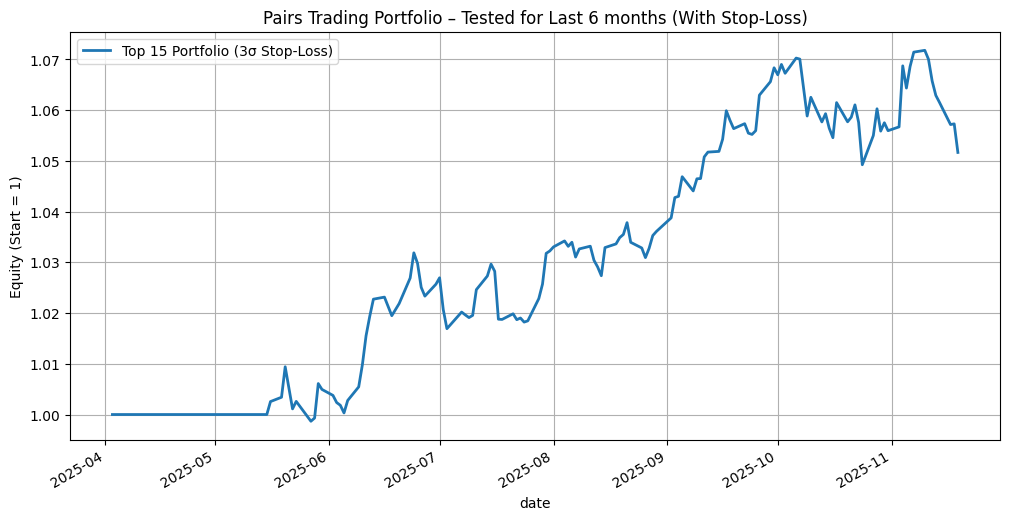

STOP LOSS EVENTS:


,date,pair,z_score,position_before
0,2025-06-03,IPG-STLD,-3.294503,1
1,2025-10-28,IPG-STLD,-3.100316,1
2,2025-10-01,GE-RJF,3.036570,-1
3,2025-10-03,FICO-LIN,3.546226,-1
4,2025-06-24,ED-SBAC,-3.259964,1
5,2025-10-16,ARE-LIN,3.056010,-1
6,2025-06-26,ACN-EQIX,3.685889,1
7,2025-07-24,EVRG-WST,-4.821875,-1
8,2025-10-23,EVRG-WST,-4.366209,1
9,2025-10-10,LIN-SO,-3.099961,1


,pair,Sharpe_cost,TotalReturn_cost
20,DDOG-TSN,2.168996,0.202946
7,EVRG-WST,2.053805,0.098436
5,ARE-LIN,1.639690,0.270023
0,ABT-LYV,1.440950,0.055993
29,UAL-VZ,1.082072,0.066658
15,DAL-HAS,1.025859,0.044398
25,GL-JBL,0.937065,0.041061
23,IQV-LYV,0.824473,0.029904
26,ABT-IQV,0.801441,0.042008
6,ACN-EQIX,0.763969,0.033583


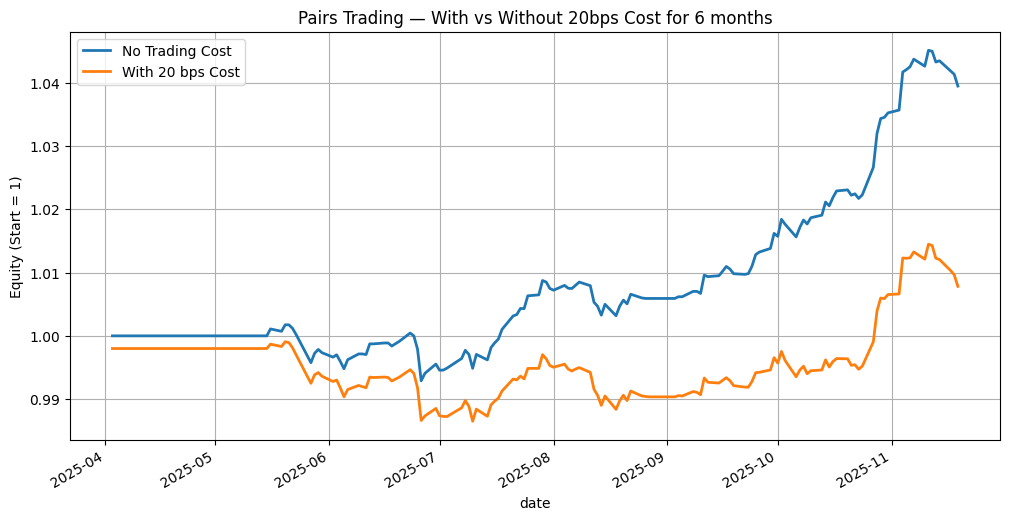

TOP STRATEGIES (COVID Crash Window)


,pair,Sharpe,TotalReturn,LastEquity
21,EVRG-LULU,2.137658,0.447617,1.447617
19,CRM-NKE,1.685042,0.247195,1.247195
2,GE-RJF,1.649526,0.648325,1.648325
4,ED-SBAC,1.545772,0.235129,1.235129
5,ARE-LIN,1.201488,0.142150,1.142150
15,DAL-HAS,1.132187,0.309459,1.309459
1,IPG-STLD,0.859641,0.174114,1.174114
16,CPB-EG,0.716540,0.121828,1.121828
28,ALB-APA,0.658569,0.134158,1.134158
14,CTAS-EQIX,0.656975,0.116233,1.116233


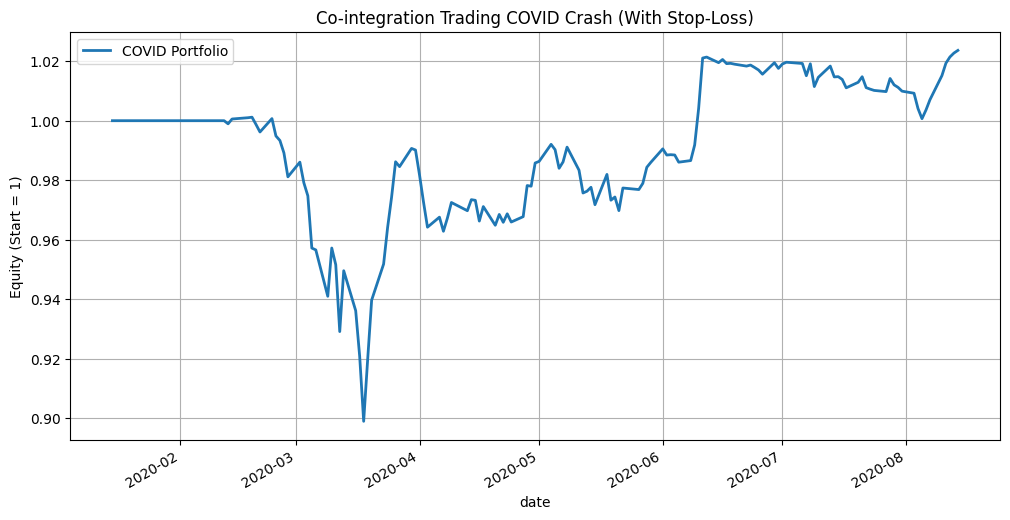

STOP LOSS EVENTS:


,date,pair,z_score,position_before
0,2020-03-16,FICO-LIN,-3.112679,1
1,2020-02-28,EG-TSN,-3.010610,1
2,2020-03-04,EA-GE,3.254650,-1
3,2020-02-28,CPB-EG,3.038359,-1
4,2020-08-05,EVRG-LULU,-3.318164,1
5,2020-02-25,LYV-WEC,-3.018660,1
6,2020-07-22,ABT-IQV,-3.080132,1


C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\3579198801.py:625: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2020-01-15", end="2020-08-15")["Close"]
[*********************100%***********************]  1 of 1 completed

CF-EXC not found in positions.


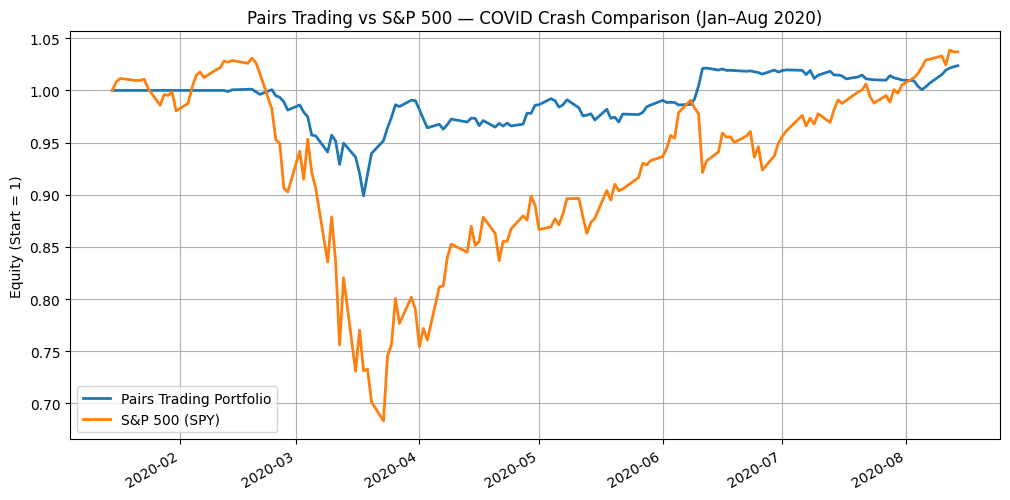

Final Values:
            Pairs Portfolio  S&P 500 (SPY)
2020-08-14         1.023644       1.036935
==== STOP LOSS EVENTS ====


,date,pair,z_score,position_before
0,2020-03-16,FICO-LIN,-3.112679,1
1,2020-02-28,EG-TSN,-3.010610,1
2,2020-03-04,EA-GE,3.254650,-1
3,2020-02-28,CPB-EG,3.038359,-1
4,2020-08-05,EVRG-LULU,-3.318164,1
5,2020-02-25,LYV-WEC,-3.018660,1
6,2020-07-22,ABT-IQV,-3.080132,1


TOP STRATEGIES (Last 6 months with 3σ Stop-Loss):


,pair,Sharpe,TotalReturn,LastEquity
26,ABT-IQV,2.086743,0.478941,1.478941
5,ARE-LIN,1.844826,0.357505,1.357505
6,ACN-EQIX,1.593524,0.221377,1.221377
27,CLX-UAL,1.489180,0.196755,1.196755
8,LIN-SO,1.344766,0.115504,1.115504
9,PPL-VRTX,0.983738,0.069503,1.069503
22,DLR-REG,0.932327,0.090548,1.090548
24,LYV-WEC,0.867785,0.138752,1.138752
1,IPG-STLD,0.756354,0.080044,1.080044
17,EQIX-SPGI,0.741498,0.106969,1.106969


STOP LOSS EVENTS:


""


In [ ]:
ohlcv.columns
px = ohlcv.pivot(index="date", columns="ticker", values="close").sort_index()
len(ohlcv.columns)

from statsmodels.tsa.stattools import adfuller #where we are getting the data. siting the source.
#which texts as well.
def check_I1(series):
    series = series.dropna()
    # Level test (should be non-stationary → p > 0.05)
    #checking for the first step of prices difference whether non-stationarity.

    p_level = adfuller(series)[1]
    # First difference test (should be stationary → p < 0.05)
    diff = series.diff().dropna()
    p_diff = adfuller(diff)[1]

    return p_level, p_diff

# ---------------------------------------------------------
#  EXCLUDE RECENT / SHORT-HISTORY STOCKS BEFORE ADF.
# ---------------------------------------------------------

min_history = int(5 * 252)   # at least 5 years of data (~1260 days)
# Count non-NaN observations per ticker
valid_tickers = [
    t for t in px.columns
    if px[t].dropna().shape[0] >= min_history
]

print("Tickers with >=5 years of data:", len(valid_tickers))
px = px[valid_tickers]

# ---------------------------------------------------------
#  testing p-value for finidng non-stationary of prices.
# ---------------------------------------------------------
results = {}
for ticker in px.columns:
    p_level, p_diff = check_I1(px[ticker])
    results[ticker] = {
        "p_level": p_level,
        "p_diff": p_diff,
        "I_1_flag": (p_level > 0.05) and (p_diff < 0.05)
    }
results_df = pd.DataFrame(results).T
print(results_df)


#keeps only the True rows so keeps only ones that are higher than 0.05 p therefore keeping stationarity.
I1_tickers = results_df[results_df["I_1_flag"] == True].index.tolist()
print("I(1) tickers:", I1_tickers)

#see how many gets filtered out.
px_I1 = px[I1_tickers]
len(px_I1.columns) #only takes out 3 stocks though ?
#visual graph. 107/110 = 97 percent of stocks are non-stationary.


#Formation testing period.
formation_length = int(504)
formation = px_I1.iloc[-formation_length:]


#formulation adjusted for the covid pandemic period to test to trade for 2020 Feb to 2022 Aug. We set formulation period for ~2 years. Switching the Formulation period requires readjusting ADF modelling ~ 7 to 8 minutes.
formation = px_I1.loc["2018-01-15":"2020-01-15"]

#Checking for the next step of checking whether spreads are stationary, then they can be co-integratred.
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# ----------------------------------------------------
# Helper: run ADF test on spread and return p-value
# ----------------------------------------------------
def adf_pvalue(series):
    return adfuller(series.dropna())[1]

# ----------------------------------------------------
# Engle–Granger cointegration test on spreads for stationarity.
# ----------------------------------------------------
pairs = list(itertools.combinations(px_I1.columns, 2))   # all 2-stock combinations
cointegrated_pairs = []

for t1, t2 in pairs:
    s1 = formation[t1].dropna()
    s2 = formation[t2].dropna()

    # align both price series by date
    df_pair = pd.concat([s1, s2], axis=1).dropna()
    if df_pair.shape[0] < 60:      # require at least 60 days (pick any threshold > 0)
      continue
    X = df_pair[t1]
    Y = df_pair[t2]

    # extra safety: constant series or NaN correlation
    if X.std() == 0 or Y.std() == 0:
        continue

    corr = X.corr(Y)
    if pd.isna(corr) or corr < 0.5:
        continue
    # --- CORRELATION FILTER GOES HERE ---
    if X.corr(Y) < 0.5:
        continue

    # 👉 PUT NORMALIZATION HERE (log transform)
    Xn = np.log(X)
    Yn = np.log(Y)

    # --- Regression using normalized (log) prices ---
    Y_const = sm.add_constant(Yn)
    result = sm.OLS(Xn, Y_const).fit()

    alpha = result.params[0]
    beta  = result.params[1]

    # spread = residuals
    spread = result.resid

    # ADF test
    p_spread = adf_pvalue(spread)
    # --- Step 1: regress X ~ Y to get alpha, beta ---
  #  Y_const = sm.add_constant(Y)
   # result = sm.OLS(X, Y_const).fit()
    #alpha = result.params[0]
 #   beta  = result.params[1]
#
    # --- Step 2: compute residuals (spread) ---
  #  spread = result.resid    # S_t = X_t - alpha - beta Y_t

    # --- Step 3: ADF test on the spread ---
   # p_spread = adf_pvalue(spread)

    # cointegration condition: spread must be stationary (p < 0.05)
    if p_spread < 0.05:
        cointegrated_pairs.append({
            "X": t1,
            "Y": t2,
            "p_value": p_spread,
            "alpha": alpha,
            "beta": beta
        })

# Put results in a DataFrame, sorted by best (lowest) p-value
coint_df = pd.DataFrame(cointegrated_pairs).sort_values("p_value")
print(coint_df)

coint_df

#filter out the stocks repeated 3 time or more.
max_pairs_per_stock = 3

filtered = []
count = {}

for _, row in coint_df.iterrows():
    X, Y = row["X"], row["Y"]

    if count.get(X, 0) < max_pairs_per_stock and count.get(Y, 0) < max_pairs_per_stock:
        filtered.append(row)
        count[X] = count.get(X, 0) + 1
        count[Y] = count.get(Y, 0) + 1

filtered_df = pd.DataFrame(filtered)

#keep 30 pairs in the basket
top30 = filtered_df.sort_values("p_value").head(30).reset_index(drop=True)
top30["pair"] = top30["X"] + "-" + top30["Y"]
top30 = top30.drop_duplicates(subset="pair")

#backtest first version w/out cost

#this is the one to use for now.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#This is testing for getting the latest data sets.


lookback_days = 160   # ~ 504 trading days
px_recent = px_I1.tail(lookback_days)

# ==========================================================
# BACKTEST PARAMETERS
# ==========================================================
window = 30        # z-score rolling window
min_length = 50   # minimum days to trade
results = []
equity_curves = {}
stop_events = []   # <- STOP-LOSS LOGGING
trades = []
# ==========================================================
# LOOP THROUGH EACH PAIR IN top30
# ==========================================================
for i, row in top30.iterrows():

    X = row["X"]#extracts stock names.
    Y = row["Y"]#extracts stock symbols
    alpha = row["alpha"]
    beta  = row["beta"]
    pos = 0                  # 0 = flat, +1 long spread, -1 short spread
    entry_spread = None
    entry_date = None


    if X not in px_recent.columns or Y not in px_recent.columns:
        continue

    # Extract price series
    px_X = px_recent[X]
    px_Y = px_recent[Y]

    # Compute spread
    spread = px_X - (alpha + beta * px_Y)
    spread = spread.dropna()

    if len(spread) < min_length:
        continue

    # Rolling z-score
    spread_mean = spread.rolling(window).mean()
    spread_std  = spread.rolling(window).std()
    z = (spread - spread_mean) / spread_std

    # ==========================================================
    # TRADING SIGNAL + 3-SIGMA STOP LOSS
    # ==========================================================
    position = pd.Series(0, index=z.index)
    state = 0   # 0 = flat, 1 = long spread, -1 = short spread

    for t, z_t in z.items():

        if state == 0:

            # ENTRY RULE: same as before
            if z_t > 1.5:
                state = -1
            elif z_t < -1.5:
                state = 1

        else:
            # STOP LOSS RULE
            if abs(z_t) >= 3:
                stop_events.append({
                    "date": t,
                    "pair": f"{X}-{Y}",
                    "z_score": z_t,
                    "position_before": state
                })
                state = 0

            # NORMAL EXIT RULE
            elif -.5 < z_t < .5:
                state = 0

        position.loc[t] = state

    # Avoid lookahead bias
    position = position.shift(1).fillna(0)

    # ==========================================================
    # COMPUTE STRATEGY RETURNS
    # ==========================================================
    ret_X = px_recent[X].pct_change()
    ret_Y = px_recent[Y].pct_change()
    spread_ret = ret_X - beta * ret_Y
    spread_ret = spread_ret.reindex(position.index).fillna(0)

    strategy_ret = position * spread_ret
    equity = (1 + strategy_ret).cumprod()

    # Store equity curve
    pair_name = f"{X}-{Y}"
    equity_curves[pair_name] = equity

    # Performance metrics
    sharpe = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252) if strategy_ret.std() > 0 else np.nan
    total_return = equity.iloc[-1] - 1

    results.append({
        "pair": pair_name,
        "Sharpe": sharpe,
        "TotalReturn": total_return,
        "LastEquity": equity.iloc[-1]
    })
# ==========================================================
# SHOW RESULTS SUMMARY TABLE

# ==========================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Sharpe", ascending=False)

print("TOP STRATEGIES (Last 6 months with 3σ Stop-Loss):")
display(results_df.head(10))

# ==========================================================
# PORTFOLIO EQUITY CURVE (AVERAGE OF ALL PAIRS)
# ==========================================================
aligned = pd.concat(equity_curves.values(), axis=1).ffill().bfill()
portfolio_equity = aligned.mean(axis=1)

plt.figure(figsize=(12,6))
portfolio_equity.plot(label="Top 15 Portfolio (3σ Stop-Loss)", linewidth=2)
plt.title("Pairs Trading Portfolio – Tested for Last 6 months (With Stop-Loss)")
plt.ylabel("Equity (Start = 1)")
plt.grid(True)
plt.legend()
plt.show()

# ==========================================================
# SHOW ALL STOP-LOSS EVENTS
# ==========================================================
stop_df = pd.DataFrame(stop_events)
print("STOP LOSS EVENTS:")
display(stop_df.head(20))

#Why do I get a repeated pair?

#duplicates exist in the pair.

#backtesting for trading cost - 2025 nov19th.
def backtest_pairs_with_cost(px_recent, top30, window=30, min_length=100, cost_bps=20):

    # --- Convert trading cost ---
    trading_cost = cost_bps / 10000  # 20 bps = 0.002

    results = []
    equity_curves_no_cost = {}
    equity_curves_cost = {}

    for _, row in top30.iterrows():

        X = row["X"]
        Y = row["Y"]
        alpha = row["alpha"]
        beta = row["beta"]

        #computation:


        # canonical pair name
        pair = "-".join(sorted([X, Y]))

        # skip tickers if missing
        if X not in px_recent.columns or Y not in px_recent.columns:
            continue

        px_X = px_recent[X]
        px_Y = px_recent[Y]

        # Compute spread
        spread = px_X - (alpha + beta * px_Y)
        spread = spread.dropna()

        if len(spread) < min_length:
            continue

        # Rolling z-score
        spread_mean = spread.rolling(window).mean()
        spread_std  = spread.rolling(window).std()
        z = (spread - spread_mean) / spread_std

        # --- Trading signal ---
        position = pd.Series(0, index=z.index)
        state = 0

        for t, z_t in z.items():

            if state == 0:
                # ENTRY
                if z_t > 2:
                    state = -1
                elif z_t < -2:
                    state = 1

            else:
                # EXIT OR STOP LOSS
                if abs(z_t) >= 3:
                    state = 0
                elif -2 < z_t < 2:
                    state = 0

            position.loc[t] = state

        # Avoid lookahead bias
        position = position.shift(1).fillna(0)

        # --- Spread returns ---
        ret_X = px_X.pct_change()
        ret_Y = px_Y.pct_change()
        spread_ret = (ret_X - beta * ret_Y).reindex(position.index).fillna(0)

        # --- Identify trade entries & exits ---
        entry_mask = (position.shift(1) == 0) & (position != 0)
        exit_mask  = (position.shift(1) != 0) & (position == 0)

        trade_costs = (entry_mask | exit_mask).astype(float) * trading_cost

        # --- Strategy returns ---
        returns_no_cost = position * spread_ret
        returns_cost    = returns_no_cost - trade_costs

        # --- Equity curves ---
        eq_no_cost = (1 + returns_no_cost).cumprod()
        eq_cost    = (1 + returns_cost).cumprod()

        equity_curves_no_cost[pair] = eq_no_cost
        equity_curves_cost[pair]    = eq_cost

        # Metrics
        sharpe_c = returns_cost.mean() / returns_cost.std() * np.sqrt(252) if returns_cost.std() > 0 else np.nan
        total_c  = eq_cost.iloc[-1] - 1

        results.append({
            "pair": pair,
            "Sharpe_cost": sharpe_c,
            "TotalReturn_cost": total_c
        })

    return pd.DataFrame(results).sort_values("Sharpe_cost", ascending=False), equity_curves_no_cost, equity_curves_cost

def plot_cost_comparison(equity_no_cost, equity_cost, title="Trading Cost Impact (20 bps)"):

    aligned_no_cost = pd.concat(equity_no_cost.values(), axis=1).ffill().bfill()
    aligned_cost    = pd.concat(equity_cost.values(), axis=1).ffill().bfill()

    port_no_cost = aligned_no_cost.mean(axis=1)
    port_cost    = aligned_cost.mean(axis=1)

    plt.figure(figsize=(12,6))
    port_no_cost.plot(label="No Trading Cost", linewidth=2)
    port_cost.plot(label="With 20 bps Cost", linewidth=2)

    plt.title(title)
    plt.ylabel("Equity (Start = 1)")
    plt.grid(True)
    plt.legend()
    plt.show()
    return port_cost

results_cost, eq_no_cost, eq_cost = backtest_pairs_with_cost(
    px_recent,
    top30,
    window=30,
    min_length=100,
    cost_bps=20
)

display(results_cost.head(10))

s = plot_cost_comparison(eq_no_cost, eq_cost, title="Pairs Trading — With vs Without 20bps Cost for 6 months")
result_coin_fixed_06 = s.copy()
result_coin_fixed_06 = result_coin_fixed_06.loc["2025-05-13":"2025-11-13"]/0.998


# ==========================================================
# COVID TEST BACKTEST
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# SELECT COVID CRASH WINDOW
# ==========================================================
px_recent = px_I1.loc["2020-01-15":"2020-08-15"]

# ==========================================================
# BACKTEST PARAMETERS
# ==========================================================
window = 20        # z-score window
min_length = 30    # min days of spread
results = []
equity_curves = {}
stop_events = []
positions_dict = {}   # <--- STORE ALL POSITIONS HERE

# ==========================================================
# LOOP THROUGH EACH PAIR IN top30
# ==========================================================
for i, row in top30.iterrows():

    X = row["X"]
    Y = row["Y"]
    alpha = row["alpha"]
    beta  = row["beta"]

    if X not in px_recent.columns or Y not in px_recent.columns:
        continue

    # Extract price series
    px_X = px_recent[X]
    px_Y = px_recent[Y]

    # Compute spread
    spread = px_X - (alpha + beta * px_Y)
    spread = spread.dropna()

    if len(spread) < min_length:
        continue

    # Rolling z-score
    spread_mean = spread.rolling(window).mean()
    spread_std  = spread.rolling(window).std()
    z = (spread - spread_mean) / spread_std

    # ==========================================================
    # TRADING SIGNALS + STOP LOSS
    # ==========================================================
    position = pd.Series(0, index=z.index)
    state = 0   # 0 flat, 1 long spread, -1 short spread

    for t, z_t in z.items():

        if state == 0:
            if z_t > 2:
                state = -1
            elif z_t < -2:
                state = 1

        else:
            # STOP LOSS
            if abs(z_t) >= 3:
                stop_events.append({
                    "date": t,
                    "pair": f"{X}-{Y}",
                    "z_score": z_t,
                    "position_before": state
                })
                state = 0

            # NORMAL EXIT
            elif -.5 < z_t <  .5:
                state = 0

        position.loc[t] = state

    position = position.shift(1).fillna(0)

    # STORE POSITION SERIES
    pair_name = f"{X}-{Y}"
    positions_dict[pair_name] = position

    # ==========================================================
    # STRATEGY RETURNS
    # ==========================================================
    ret_X = px_X.pct_change()
    ret_Y = px_Y.pct_change()
    spread_ret = ret_X - beta * ret_Y
    spread_ret = spread_ret.reindex(position.index).fillna(0)

    strategy_ret = position * spread_ret
    equity = (1 + strategy_ret).cumprod()
    equity_curves[pair_name] = equity

    # PERFORMANCE STATS
    sharpe = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252) if strategy_ret.std() > 0 else np.nan
    total_return = equity.iloc[-1] - 1

    results.append({
        "pair": pair_name,
        "Sharpe": sharpe,
        "TotalReturn": total_return,
        "LastEquity": equity.iloc[-1]
    })


# ==========================================================
# SHOW RESULTS SUMMARY
# ==========================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Sharpe", ascending=False)

print("TOP STRATEGIES (COVID Crash Window)")
display(results_df.head(10))

# ==========================================================
# PORTFOLIO EQUITY CURVE
# ==========================================================
aligned = pd.concat(equity_curves.values(), axis=1).ffill().bfill()
portfolio_equity = aligned.mean(axis=1)

plt.figure(figsize=(12,6))
portfolio_equity.plot(label="COVID Portfolio", linewidth=2)
plt.title("Co-integration Trading COVID Crash (With Stop-Loss)")
plt.ylabel("Equity (Start = 1)")
plt.grid(True)
plt.legend()
plt.show()

# ==========================================================
# STOP LOSS EVENTS
# ==========================================================
stop_df = pd.DataFrame(stop_events)
print("STOP LOSS EVENTS:")
display(stop_df.head(20))

# ==========================================================
# CF–EXC TRADE COUNT + ENTRY DATES
# ==========================================================
pair = "CF-EXC"

if pair in positions_dict:

    pos = positions_dict[pair]

    # Trade detection: enter whenever 0 → non-zero
    entries = pos[(pos.shift(1) == 0) & (pos != 0)]

    print(f"\n=== {pair} TRADE ENTRIES ===")
    print(entries)

    print(f"\nTotal trades executed for {pair}: {len(entries)}")

else:
    print(f"{pair} not found in positions.")



# ==========================================================
# LOAD SP500 (SPY) FOR SAME COVID WINDOW
# ==========================================================
import yfinance as yf

spy = yf.download("SPY", start="2020-01-15", end="2020-08-15")["Close"]
spy = spy.pct_change().fillna(0)
spy_equity = (1 + spy).cumprod()
spy_equity.name = "S&P 500 (SPY)"

# ALIGN WITH PAIRS PORTFOLIO DATES
combined = pd.concat([portfolio_equity, spy_equity], axis=1).dropna()
combined.columns = ["Pairs Portfolio", "S&P 500 (SPY)"]

# ==========================================================
# PLOT COMPARISON
# ==========================================================
plt.figure(figsize=(12,6))
combined["Pairs Portfolio"].plot(label="Pairs Trading Portfolio", linewidth=2)
combined["S&P 500 (SPY)"].plot(label="S&P 500 (SPY)", linewidth=2)

plt.title("Pairs Trading vs S&P 500 — COVID Crash Comparison (Jan–Aug 2020)")
plt.ylabel("Equity (Start = 1)")
plt.grid(True)
plt.legend()
plt.show()

# ==========================================================
# SHOW ENDPOINT RETURNS
# ==========================================================
print("Final Values:")
print(combined.tail(1))


#List of the ones that triggered stopping points.

stop_df = pd.DataFrame(stop_events)
print("==== STOP LOSS EVENTS ====")
display(stop_df)


#Testing for the 10 years period.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#This is testing for getting the latest data sets.

# ==========================================================
# USE ONLY THE LAST 6 MONTHS OF PRICE DATA
# ==========================================================

lookback_days = 160   # ~ 504 trading days
px_recent = px_I1.tail(lookback_days)

# ==========================================================
# BACKTEST PARAMETERS
# ==========================================================
window = 30        # z-score rolling window
min_length = 100   # minimum days to trade
results = []
equity_curves = {}
stop_events = []   # <- STOP-LOSS LOGGING
trades = []
# ==========================================================
# LOOP THROUGH EACH PAIR IN top30
# ==========================================================
for i, row in top30.iterrows():

    X = row["X"]#extracts stock names.
    Y = row["Y"]#extracts stock symbols
    alpha = row["alpha"]
    beta  = row["beta"]
    pos = 0                  # 0 = flat, +1 long spread, -1 short spread
    entry_spread = None
    entry_date = None


    if X not in px_recent.columns or Y not in px_recent.columns:
        continue

    # Extract price series
    px_X = px_recent[X]
    px_Y = px_recent[Y]

    # Compute spread
    spread = px_X - (alpha + beta * px_Y)
    spread = spread.dropna()

    if len(spread) < min_length:
        continue

    # Rolling z-score
    spread_mean = spread.rolling(window).mean()
    spread_std  = spread.rolling(window).std()
    z = (spread - spread_mean) / spread_std

    # ==========================================================
    # TRADING SIGNAL + 3-SIGMA STOP LOSS
    # ==========================================================
    position = pd.Series(0, index=z.index)
    state = 0   # 0 = flat, 1 = long spread, -1 = short spread

    for t, z_t in z.items():

        if state == 0:

            # ENTRY RULE: same as before
            if z_t > 2:
                state = -1
            elif z_t < -2:
                state = 1
                state = 0

            # NORMAL EXIT RULE
            elif -0.5 < z_t < 0.5:
                state = 0

        position.loc[t] = state

    # Avoid lookahead bias
    position = position.shift(1).fillna(0)

    # ==========================================================
    # COMPUTE STRATEGY RETURNS
    # ==========================================================
    ret_X = px_recent[X].pct_change()
    ret_Y = px_recent[Y].pct_change()
    spread_ret = ret_X - beta * ret_Y
    spread_ret = spread_ret.reindex(position.index).fillna(0)

    strategy_ret = position * spread_ret
    equity = (1 + strategy_ret).cumprod()

    # Store equity curve
    pair_name = f"{X}-{Y}"
    equity_curves[pair_name] = equity

    # Performance metrics
    sharpe = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252) if strategy_ret.std() > 0 else np.nan
    total_return = equity.iloc[-1] - 1

    results.append({
        "pair": pair_name,
        "Sharpe": sharpe,
        "TotalReturn": total_return,
        "LastEquity": equity.iloc[-1]
    })
# ==========================================================
# SHOW RESULTS SUMMARY TABLE
# ==========================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Sharpe", ascending=False)

print("TOP STRATEGIES (Last 6 months with 3σ Stop-Loss):")
display(results_df.head(10))

# ==========================================================
# PORTFOLIO EQUITY CURVE (AVERAGE OF ALL PAIRS)
# ==========================================================
#aligned = pd.concat(equity_curves.values(), axis=1).ffill().bfill()
#portfolio_equity = aligned.mean(axis=1)

#plt.figure(figsize=(12,6))
#portfolio_equity.plot(label="Top 15 Portfolio (3σ Stop-Loss)", linewidth=2)
#plt.title("Pairs Trading Portfolio – Tested for Last 6 months (With Stop-Loss)")
#plt.ylabel("Equity (Start = 1)")
#plt.grid(True)
#plt.legend()
#plt.show()

# ==========================================================
# SHOW ALL STOP-LOSS EVENTS
# ==========================================================
stop_df = pd.DataFrame(stop_events)
print("STOP LOSS EVENTS:")
display(stop_df.head(20))

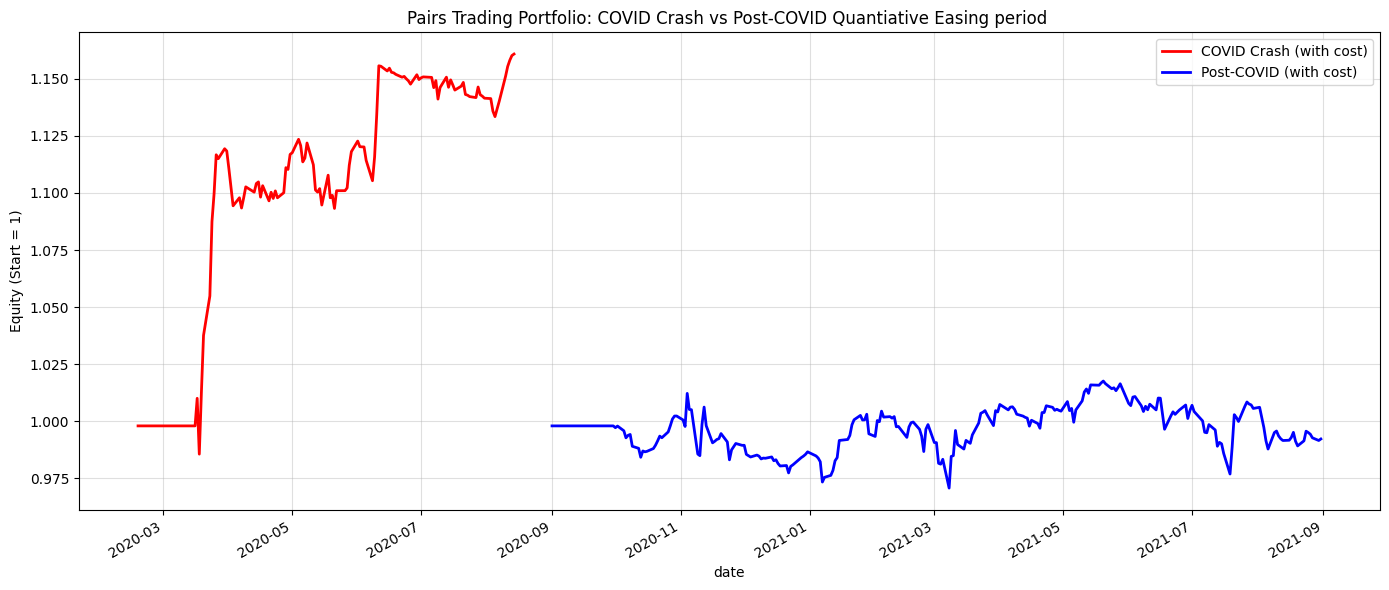

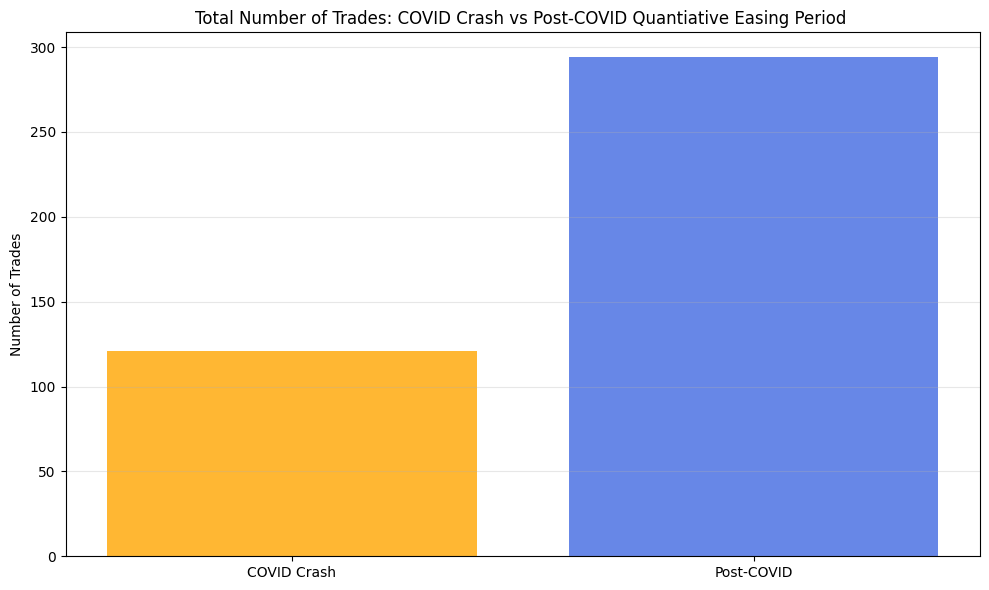

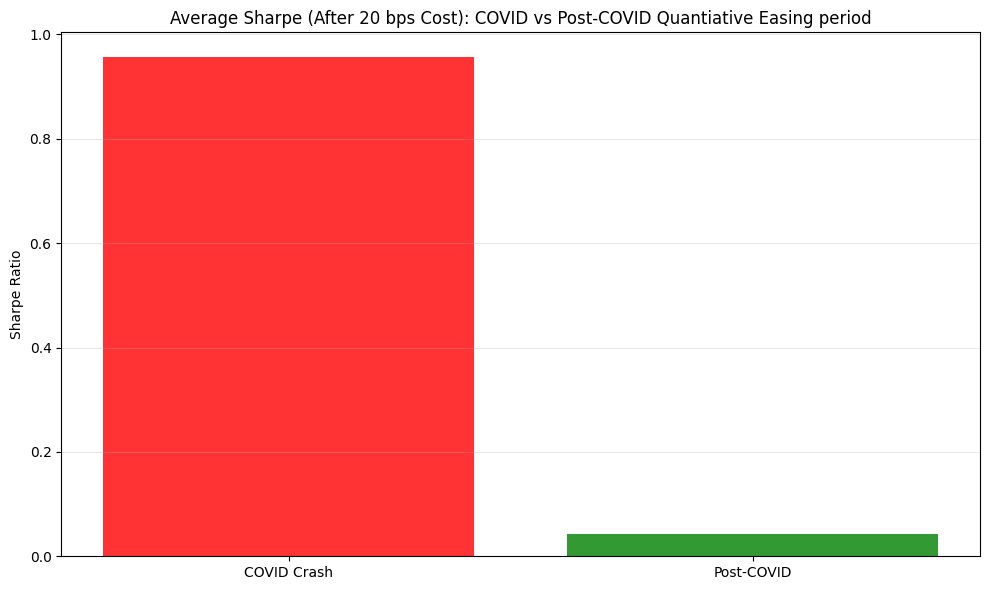

COVID Total Trading Cost: 0.6105123296613488
Post-COVID Total Trading Cost: 1.230225727853856
COVID Avg Cost per Pair: 0.02035041098871163
Post-COVID Avg Cost per Pair: 0.0410075242617952


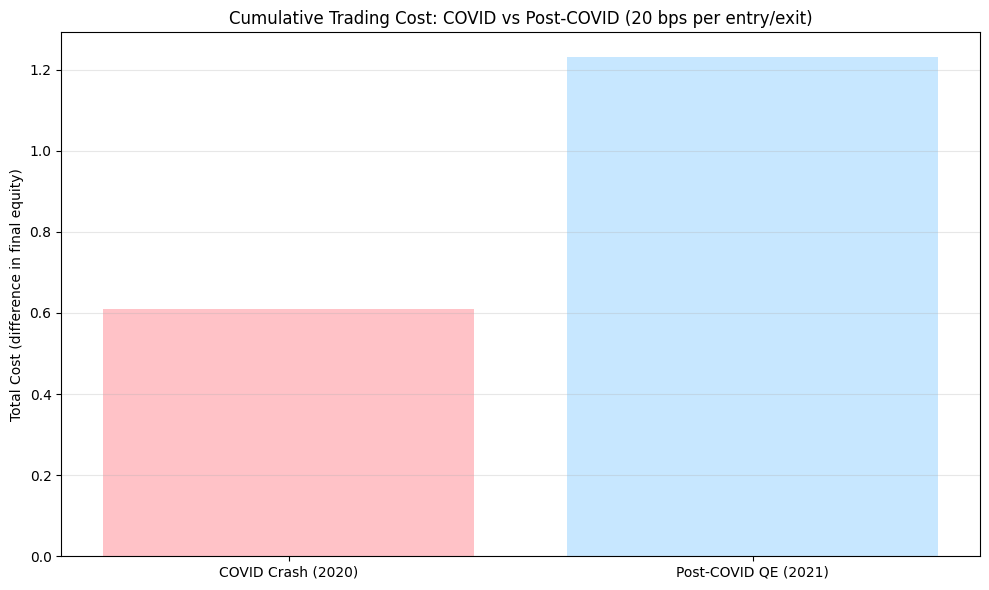

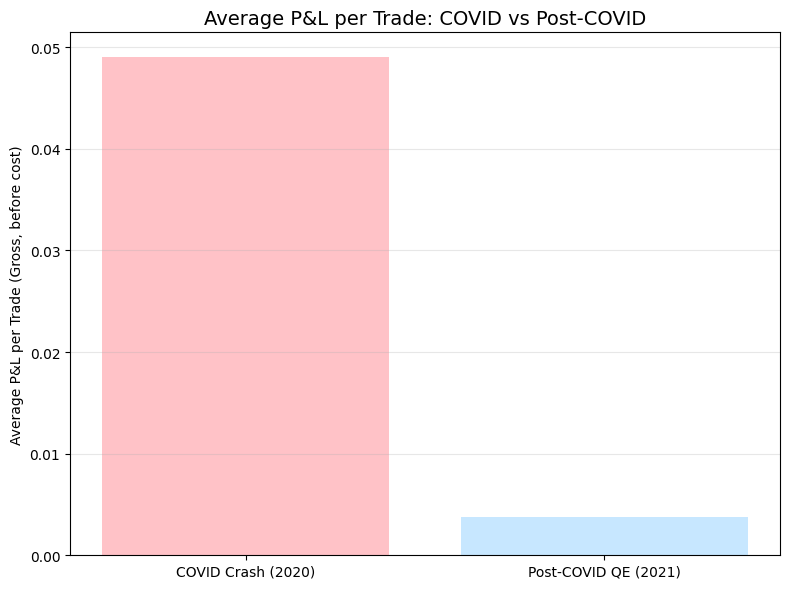

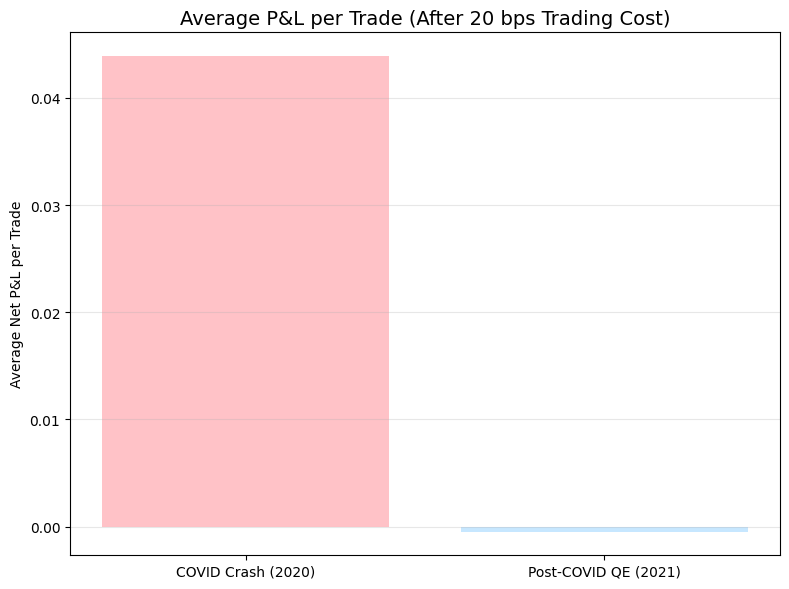

In [ ]:
#edited after presentation for co-integration testing trarding frequency and cost for covid vs post-covid period.

#Edited after final presentation of Nov 20th. below comments are based on the comments we received from Nov 20th, the date of our final presentation.

#during this time, we received feedback about running a possible trading cost and frequency of the trade analysis. So we picked the timeframe for co-integration fixed window in Covid period from Feb of 2020 to August 2020
#vs September 2020 to August 2021. As a result, we noticed Covid Period with around 125 trades, Post-Covid as around 290 trades. Also, Noticeably Sharp Ratio for covid was 0.8 while Post covid was 0.05. This indicates
#that as volatiilty exploded, the sigma scale increased dramatically and z-score has denominator as the sigma scale. So due to the z-score value reduced, which suppressed the number of trades that exceeded the 1.5 to 2.0 sigma threshold
#to exit and enter trades. On the other hand, the sharp ratio during covid was substantially high indcating stronger opportunities with stronger mean-reversion (spread quickly reached equilibrium) and provided profits. For post-covid,
#there were many trades but weaker mean-reversion of spread as the sharp ratio was low as the post-covid period that had low volatility due to high liquidation in the market causing many signals and trades but weak profits.
#Also, in terms of cost analysis, we see that P&L for each of the Covid Trade is extremely high with 0.03 average pnl per trade covid vs  0.0025 average pnl per trade for post covid as covid had few traedes with high returns and post covid had
#high trades with low returns. The Net P&L/trade is near zero or negative and interestingly the trading cost analysis indicate that 20bps cost brings down the PnL to less than zero completely.

def run_pairs_backtest_with_cost(px, top30, start_date, end_date,
                                 window=20, min_length=50, cost_bps=20):

    px_period = px.loc[start_date:end_date].copy()
    trading_cost = cost_bps / 10000  # 20 bps = 0.002

    results = []
    equity_curves_cost = {}
    equity_curves_no_cost = {}
    trade_counts = {}

    for _, row in top30.iterrows():
        X, Y = row["X"], row["Y"]
        alpha, beta = row["alpha"], row["beta"]
        pair = row["pair"]

        if X not in px_period.columns or Y not in px_period.columns:
            continue

        px_X = px_period[X]
        px_Y = px_period[Y]

        spread = px_X - (alpha + beta * px_Y)
        spread = spread.dropna()
        if len(spread) < min_length:
            continue

        spread_mean = spread.rolling(window).mean()
        spread_std  = spread.rolling(window).std()
        z = (spread - spread_mean) / spread_std

        position = pd.Series(0, index=z.index)
        state = 0

        for t, z_t in z.items():
            if state == 0:
                if z_t > 2:
                    state = -1
                elif z_t < -2:
                    state = 1
            else:
                if abs(z_t) >= 3:
                    state = 0
                elif -0.5 < z_t < 0.5:
                    state = 0

            position.loc[t] = state

        position = position.shift(1).fillna(0)

        ret_X = px_X.pct_change()
        ret_Y = px_Y.pct_change()
        spread_ret = (ret_X - beta * ret_Y).reindex(position.index).fillna(0)

        entry_mask = (position.shift(1) == 0) & (position != 0)
        exit_mask  = (position.shift(1) != 0) & (position == 0)
        trade_costs = (entry_mask | exit_mask) * trading_cost

        trade_counts[pair] = entry_mask.sum()

        returns_no_cost = position * spread_ret
        returns_cost = returns_no_cost - trade_costs

        eq_no_cost = (1 + returns_no_cost).cumprod()
        eq_cost    = (1 + returns_cost).cumprod()

        equity_curves_no_cost[pair] = eq_no_cost
        equity_curves_cost[pair]    = eq_cost

        sharpe_cost = returns_cost.mean() / returns_cost.std() * np.sqrt(252) if returns_cost.std() > 0 else np.nan

        results.append({
            "pair": pair,
            "Sharpe_cost": sharpe_cost,
            "TotalReturn_cost": eq_cost.iloc[-1] - 1,
            "Trades": entry_mask.sum()
        })

    results_df = pd.DataFrame(results).sort_values("Sharpe_cost", ascending=False)

    return results_df, equity_curves_no_cost, equity_curves_cost
# COVID regime
covid_results, covid_no_cost, covid_cost = run_pairs_backtest_with_cost(
    px_I1, top30,
    start_date="2020-02-15",
    end_date="2020-08-15",
    window=20,
    min_length=30,
    cost_bps=20
)

# Post-COVID regime
post_results, post_no_cost, post_cost = run_pairs_backtest_with_cost(
    px_I1, top30,
    start_date="2020-09-01",
    end_date="2021-08-31",
    window=20,
    min_length=30,
    cost_bps=20
)
def portfolio_equity(eq_dict):
    aligned = pd.concat(eq_dict.values(), axis=1).ffill().bfill()
    return aligned.mean(axis=1)
covid_port = portfolio_equity(covid_cost)
post_port  = portfolio_equity(post_cost)

plt.figure(figsize=(14,6))
covid_port.plot(label="COVID Crash (with cost)", linewidth=2, color="red")
post_port.plot(label="Post-COVID (with cost)", linewidth=2, color="blue")

plt.title("Pairs Trading Portfolio: COVID Crash vs Post-COVID Quantiative Easing period ")
plt.ylabel("Equity (Start = 1)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))

plt.bar(["COVID Crash", "Post-COVID"],
        [covid_results["Trades"].sum(),
         post_results["Trades"].sum()],
        color=["orange", "royalblue"], alpha=0.8)

plt.title("Total Number of Trades: COVID Crash vs Post-COVID Quantiative Easing Period ")
plt.ylabel("Number of Trades")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

covid_sharpe = covid_results["Sharpe_cost"].mean()
post_sharpe  = post_results["Sharpe_cost"].mean()

plt.figure(figsize=(10,6))
plt.bar(["COVID Crash", "Post-COVID"],
        [covid_sharpe, post_sharpe],
        color=["red", "green"], alpha=0.8)

plt.title("Average Sharpe (After 20 bps Cost): COVID vs Post-COVID Quantiative Easing period")
plt.ylabel("Sharpe Ratio")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

#COVID Crash trades ≈ 125

#Post-COVID trades ≈ 290


def compute_cumulative_trading_cost(eq_no_cost_dict, eq_cost_dict):
    """
    Computes cumulative trading cost by comparing no-cost vs cost equity curves.

    Returns:
        total_cost, avg_cost_per_pair
    """
    total_cost = 0
    pair_costs = {}

    for pair in eq_no_cost_dict.keys():
        eq_nc = eq_no_cost_dict[pair]
        eq_c  = eq_cost_dict[pair]

        # Cost = difference in final equity value
        cost = (eq_nc.iloc[-1] - eq_c.iloc[-1])
        pair_costs[pair] = cost
        total_cost += cost

    avg_cost = total_cost / len(eq_no_cost_dict)

    return total_cost, avg_cost, pair_costs
# COVID cost analysis
covid_total_cost, covid_avg_cost, covid_costs_by_pair = compute_cumulative_trading_cost(
    covid_no_cost, covid_cost
)

# Post-COVID cost analysis
post_total_cost, post_avg_cost, post_costs_by_pair = compute_cumulative_trading_cost(
    post_no_cost, post_cost
)

print("COVID Total Trading Cost:", covid_total_cost)
print("Post-COVID Total Trading Cost:", post_total_cost)

print("COVID Avg Cost per Pair:", covid_avg_cost)
print("Post-COVID Avg Cost per Pair:", post_avg_cost)

import matplotlib.pyplot as plt

pastel_colors = ["#FFB3BA", "#BAE1FF"]  # soft pastel red/pink and pastel sky blue

plt.figure(figsize=(10,6))
plt.bar(
    ["COVID Crash (2020)", "Post-COVID QE (2021)"],
    [covid_total_cost, post_total_cost],
    color=pastel_colors,
    alpha=0.8
)



plt.title("Cumulative Trading Cost: COVID vs Post-COVID (20 bps per entry/exit)")
plt.ylabel("Total Cost (difference in final equity)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

def compute_avg_pnl_per_trade(eq_no_cost_dict, results_df):
    pair_pnl = {}
    pair_avg_pnl = {}

    for pair in eq_no_cost_dict.keys():
        eq_nc = eq_no_cost_dict[pair]
        gross_pnl = eq_nc.iloc[-1] - 1   # final equity -1 = gross return
        trades = results_df.loc[results_df["pair"] == pair, "Trades"].values[0]

        if trades > 0:
            avg_pnl = gross_pnl / trades
        else:
            avg_pnl = 0

        pair_pnl[pair] = gross_pnl
        pair_avg_pnl[pair] = avg_pnl

    return pair_avg_pnl
covid_avg_pnl = compute_avg_pnl_per_trade(covid_no_cost, covid_results)
post_avg_pnl  = compute_avg_pnl_per_trade(post_no_cost, post_results)

# Convert to DataFrame for easier plotting
df_compare = pd.DataFrame({
    "COVID_avg_PnL": [np.mean(list(covid_avg_pnl.values()))],
    "PostCOVID_avg_PnL": [np.mean(list(post_avg_pnl.values()))]
}).T

df_compare.columns = ["Avg_PnL_per_Trade"]
df_compare

plt.figure(figsize=(8,6))

plt.bar(
    ["COVID Crash (2020)", "Post-COVID QE (2021)"],
    [df_compare.loc["COVID_avg_PnL"].values[0],
     df_compare.loc["PostCOVID_avg_PnL"].values[0]],
    color=pastel_colors ,
    alpha=0.8
)

plt.title("Average P&L per Trade: COVID vs Post-COVID", fontsize=14)
plt.ylabel("Average P&L per Trade (Gross, before cost)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

def compute_avg_pnl_per_trade_after_cost(eq_cost_dict, results_df):
    pair_avg_pnl_after_cost = {}

    for pair in eq_cost_dict.keys():
        eq_c = eq_cost_dict[pair]
        net_pnl = eq_c.iloc[-1] - 1       # equity - 1 gives total return after cost

        trades = results_df.loc[results_df["pair"] == pair, "Trades"].values[0]

        if trades > 0:
            avg_pnl = net_pnl / trades
        else:
            avg_pnl = 0

        pair_avg_pnl_after_cost[pair] = avg_pnl

    return pair_avg_pnl_after_cost
covid_avg_pnl_after = compute_avg_pnl_per_trade_after_cost(covid_cost, covid_results)
post_avg_pnl_after  = compute_avg_pnl_per_trade_after_cost(post_cost, post_results)

# Compute the mean across all pairs
covid_avg_value = np.mean(list(covid_avg_pnl_after.values()))
post_avg_value  = np.mean(list(post_avg_pnl_after.values()))

df_after = pd.DataFrame({
    "Period": ["COVID Crash (2020)", "Post-COVID QE (2021)"],
    "Avg PnL per Trade (After Cost)": [covid_avg_value, post_avg_value]
})
df_after

plt.figure(figsize=(8,6))

plt.bar(
    df_after["Period"],
    df_after["Avg PnL per Trade (After Cost)"],
    color=pastel_colors ,
    alpha=0.8
)

plt.title("Average P&L per Trade (After 20 bps Trading Cost)", fontsize=14)
plt.ylabel("Average Net P&L per Trade")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 2 - Rolling Window

#### Pairs selection (top 15 pairs)

In [ ]:
# VERSION 3 pairs selection (top 15 pairs) + half-life calculation

import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# ohlcv: your DataFrame with columns like:
# ['date','Ticker','open','high','low','close','adj_close','volume',
#  'name','GICS Sector','GICS Sub-Industry']

# ----------------------------------------------------------------------
# 0. Basic prep - use ALL data
# ----------------------------------------------------------------------
ohlcv = ohlcv.copy()
ohlcv['date'] = pd.to_datetime(ohlcv['date'])
ohlcv = ohlcv.sort_values('date')

price_col = 'close'   # or 'adj_close' if you prefer

# ----------------------------------------------------------------------
# 1. Make Date x Ticker matrix of log prices (full sample)
# ----------------------------------------------------------------------
price_panel = (
    ohlcv
    .pivot_table(index='date', columns='Ticker', values=price_col)
    .sort_index()
)

log_panel = np.log(price_panel)

print("Price data from", log_panel.index.min().date(), "to", log_panel.index.max().date())
print("Number of tickers:", log_panel.shape[1])

# ----------------------------------------------------------------------
# Helper: half-life from residuals
# ----------------------------------------------------------------------
def halflife_from_residuals(resid: pd.Series) -> float:
    """
    Estimate half-life of mean reversion (in days) from residual series.
    Uses Δe_t = a + b e_{t-1} + eps_t; half-life = -ln(2)/b if b < 0 else NaN.
    """
    r = resid.dropna()
    if len(r) < 30:
        return np.nan

    # Δe_t and lagged e_{t-1}
    delta = r.diff().dropna()
    lag = r.shift(1).dropna()
    # align indices
    delta = delta.loc[lag.index]

    X = sm.add_constant(lag.values)
    model = sm.OLS(delta.values, X).fit()
    b = model.params[1]  # slope on lagged residual

    if b >= 0:
        return np.nan

    return float(-np.log(2) / b)  # in days (same units as data frequency)

# ----------------------------------------------------------------------
# 2. Engle–Granger for a single pair in a given formation window
# ----------------------------------------------------------------------
def engle_granger_pair(log_prices, y_ticker, x_ticker):
    y = log_prices[y_ticker].dropna()
    x = log_prices[x_ticker].dropna()

    df = pd.concat([y, x], axis=1, keys=['y', 'x']).dropna()
    if len(df) < 30:
        return None

    y = df['y']
    x = df['x']

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    alpha = model.params['const']
    beta  = model.params['x']      # hedge ratio

    resid = model.resid
    adf_res = adfuller(resid, maxlag=1, autolag='AIC')
    adf_stat = adf_res[0]
    adf_p    = adf_res[1]

    # half-life from residuals
    half_life = halflife_from_residuals(resid)

    return {
        'y': y_ticker,
        'x': x_ticker,
        'alpha': alpha,
        'beta': beta,
        'adf_stat': adf_stat,
        'adf_p': adf_p,
        'n_obs': len(df),
        'half_life': half_life
    }

# ----------------------------------------------------------------------
# 3. Rolling formation/trading schedule (12m formation, 6m trading)
#    -> using exact first_date + 12 months as first t0,
#       then stepping by 1-month DateOffset (keeps day-of-month)
# ----------------------------------------------------------------------
first_date   = log_panel.index.min()
last_date    = log_panel.index.max()

formation_len = 12  # months
trading_len   = 6   # months

# first rebalance date: exactly 12 months after first_date
first_rebal = first_date + pd.DateOffset(months=formation_len)
# last rebalance date: so that a full trading window fits
last_rebal  = last_date - pd.DateOffset(months=trading_len)

# monthly steps preserving the day-of-month of first_rebal
rebal_dates = pd.date_range(
    start=first_rebal,
    end=last_rebal,
    freq=pd.DateOffset(months=1)
)

print("Formation/trading start dates (t0) from", rebal_dates[0].date(), "to", rebal_dates[-1].date())
print("Number of formation windows:", len(rebal_dates))

# ----------------------------------------------------------------------
# 4. For each formation window, test ALL pairs in the universe
# ----------------------------------------------------------------------
results = []

for t0 in rebal_dates:
    form_start = t0 - pd.DateOffset(months=formation_len)
    form_end   = t0 - pd.Timedelta(days=1)

    trade_start = t0
    trade_end   = t0 + pd.DateOffset(months=trading_len) - pd.Timedelta(days=1)

    window_prices = log_panel.loc[form_start:form_end]

    # tickers with at least some data in this window
    tickers_alive = window_prices.columns[window_prices.notna().sum() > 0]
    tickers_alive = list(tickers_alive)

    print(
        f"\nFormation {form_start.date()}–{form_end.date()}  "
        f"Trading {trade_start.date()}–{trade_end.date()}  "
        f"Universe size: {len(tickers_alive)}"
    )

    for y_ticker, x_ticker in itertools.combinations(tickers_alive, 2):
        res = engle_granger_pair(window_prices, y_ticker, x_ticker)
        if res is None:
            continue
        res.update({
            'formation_start': form_start,
            'formation_end': form_end,
            'trading_start': trade_start,
            'trading_end': trade_end,
        })
        results.append(res)

pair_results = pd.DataFrame(results)

# ----------------------------------------------------------------------
# 5. Pick top cointegrated pairs per window (top 15 by ADF statistic)
# ----------------------------------------------------------------------
pair_results['window_id'] = pair_results['formation_start'].dt.to_period('M')

top_pairs = (
    pair_results
    .sort_values(['window_id', 'adf_stat'])   # more negative = stronger cointegration
    .groupby('window_id')
    .head(15)
    .reset_index(drop=True)
)

print("\nTop pairs (first few rows):")
print(top_pairs.head(20))


Price data from 2015-11-16 to 2025-11-12
Number of tickers: 110
Formation/trading start dates (t0) from 2016-11-16 to 2025-04-16
Number of formation windows: 102

Formation 2015-11-16–2016-11-15  Trading 2016-11-16–2017-05-15  Universe size: 103

Formation 2015-12-16–2016-12-15  Trading 2016-12-16–2017-06-15  Universe size: 103

Formation 2016-01-16–2017-01-15  Trading 2017-01-16–2017-07-15  Universe size: 103

Formation 2016-02-16–2017-02-15  Trading 2017-02-16–2017-08-15  Universe size: 103

Formation 2016-03-16–2017-03-15  Trading 2017-03-16–2017-09-15  Universe size: 103

Formation 2016-04-16–2017-04-15  Trading 2017-04-16–2017-10-15  Universe size: 103

Formation 2016-05-16–2017-05-15  Trading 2017-05-16–2017-11-15  Universe size: 103

Formation 2016-06-16–2017-06-15  Trading 2017-06-16–2017-12-15  Universe size: 103

Formation 2016-07-16–2017-07-15  Trading 2017-07-16–2018-01-15  Universe size: 103

Formation 2016-08-16–2017-08-15  Trading 2017-08-16–2018-02-15  Universe size: 10

#### Pairs selection (top 15 pairs) + half-life

In [ ]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# ohlcv: your DataFrame with columns like:
# ['date','Ticker','open','high','low','close','adj_close','volume',
#  'name','GICS Sector','GICS Sub-Industry']

# ----------------------------------------------------------------------
# 0. Basic prep - use ALL data
# ----------------------------------------------------------------------
ohlcv = ohlcv.copy()
ohlcv['date'] = pd.to_datetime(ohlcv['date'])
ohlcv = ohlcv.sort_values('date')

price_col = 'close'   # or 'adj_close' if you prefer

# ----------------------------------------------------------------------
# 1. Make Date x Ticker matrix of log prices (full sample)
# ----------------------------------------------------------------------
price_panel = (
    ohlcv
    .pivot_table(index='date', columns='ticker', values=price_col)
    .sort_index()
)

log_panel = np.log(price_panel)

print("Price data from", log_panel.index.min().date(), "to", log_panel.index.max().date())
print("Number of tickers:", log_panel.shape[1])

# ----------------------------------------------------------------------
# Helper: half-life from residuals
# ----------------------------------------------------------------------
def halflife_from_residuals(resid: pd.Series) -> float:
    """
    Estimate half-life of mean reversion (in days) from residual series.
    Uses Δe_t = a + b e_{t-1} + eps_t; half-life = -ln(2)/b if b < 0 else NaN.
    """
    r = resid.dropna()
    if len(r) < 30:
        return np.nan

    # Δe_t and lagged e_{t-1}
    delta = r.diff().dropna()
    lag = r.shift(1).dropna()
    # align indices
    delta = delta.loc[lag.index]

    X = sm.add_constant(lag.values)
    model = sm.OLS(delta.values, X).fit()
    b = model.params[1]  # slope on lagged residual

    if b >= 0:
        return np.nan

    return float(-np.log(2) / b)  # in days (same units as data frequency)

# ----------------------------------------------------------------------
# 2. Engle–Granger for a single pair in a given formation window
# ----------------------------------------------------------------------
def engle_granger_pair(log_prices, y_ticker, x_ticker):
    y = log_prices[y_ticker].dropna()
    x = log_prices[x_ticker].dropna()

    df = pd.concat([y, x], axis=1, keys=['y', 'x']).dropna()
    if len(df) < 30:
        return None

    y = df['y']
    x = df['x']

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    alpha = model.params['const']
    beta  = model.params['x']      # hedge ratio

    resid = model.resid
    adf_res = adfuller(resid, maxlag=1, autolag='AIC')
    adf_stat = adf_res[0]
    adf_p    = adf_res[1]

    # half-life from residuals
    half_life = halflife_from_residuals(resid)

    return {
        'y': y_ticker,
        'x': x_ticker,
        'alpha': alpha,
        'beta': beta,
        'adf_stat': adf_stat,
        'adf_p': adf_p,
        'n_obs': len(df),
        'half_life': half_life
    }

# ----------------------------------------------------------------------
# 3. Rolling formation/trading schedule (12m formation, 6m trading)
# ----------------------------------------------------------------------
first_date   = log_panel.index.min()
last_date    = log_panel.index.max()

formation_len = 12  # months
trading_len   = 6   # months

first_rebal = first_date + pd.DateOffset(months=formation_len)
last_rebal  = last_date - pd.DateOffset(months=trading_len)

rebal_dates = pd.date_range(first_rebal, last_rebal, freq='MS')  # month starts

print("Formation/trading start dates (t0) from", first_rebal.date(), "to", last_rebal.date())
print("Number of formation windows:", len(rebal_dates))

# ----------------------------------------------------------------------
# 4. For each formation window, test ALL pairs in the universe
# ----------------------------------------------------------------------
results = []

for t0 in rebal_dates:
    form_start = t0 - pd.DateOffset(months=formation_len)
    form_end   = t0 - pd.Timedelta(days=1)

    trade_start = t0
    trade_end   = t0 + pd.DateOffset(months=trading_len) - pd.Timedelta(days=1)

    window_prices = log_panel.loc[form_start:form_end]

    # tickers with at least some data in this window
    tickers_alive = window_prices.columns[window_prices.notna().sum() > 0]
    tickers_alive = list(tickers_alive)

    print(
        f"\nFormation {form_start.date()}–{form_end.date()}  "
        f"Trading {trade_start.date()}–{trade_end.date()}  "
        f"Universe size: {len(tickers_alive)}"
    )

    for y_ticker, x_ticker in itertools.combinations(tickers_alive, 2):
        res = engle_granger_pair(window_prices, y_ticker, x_ticker)
        if res is None:
            continue
        res.update({
            'formation_start': form_start,
            'formation_end': form_end,
            'trading_start': trade_start,
            'trading_end': trade_end,
        })
        results.append(res)

pair_results = pd.DataFrame(results)

# ----------------------------------------------------------------------
# 5. Pick top cointegrated pairs per window (top 15 by ADF statistic)
# ----------------------------------------------------------------------
pair_results['window_id'] = pair_results['formation_start'].dt.to_period('M')

top_pairs = (
    pair_results
    .sort_values(['window_id', 'adf_stat'])   # more negative = stronger cointegration
    .groupby('window_id')
    .head(15)
    .reset_index(drop=True)
)

print("\nTop pairs (first few rows):")
print(top_pairs.head(20))


Price data from 2015-11-23 to 2025-11-19
Number of tickers: 110
Formation/trading start dates (t0) from 2016-11-23 to 2025-05-19
Number of formation windows: 102

Formation 2015-12-01–2016-11-30  Trading 2016-12-01–2017-05-31  Universe size: 103


KeyboardInterrupt: 

#### BACKTEST: 1Y WITH TC

1Y window from 2024-11-19 to 2025-11-19
Final cumulative return (gross, 1Y): 0.0842
Final equity gross (start = 1):      1.0842
Final cumulative return (net, 1Y):   0.0448
Final equity net (start = 1):        1.0448
Total transaction fee (avg/day sum): 0.0371
Annualized mean (net, 1Y):           0.0482
Annualized vol  (net, 1Y):           0.0917
Sharpe (daily -> annual, net, 1Y):   0.53


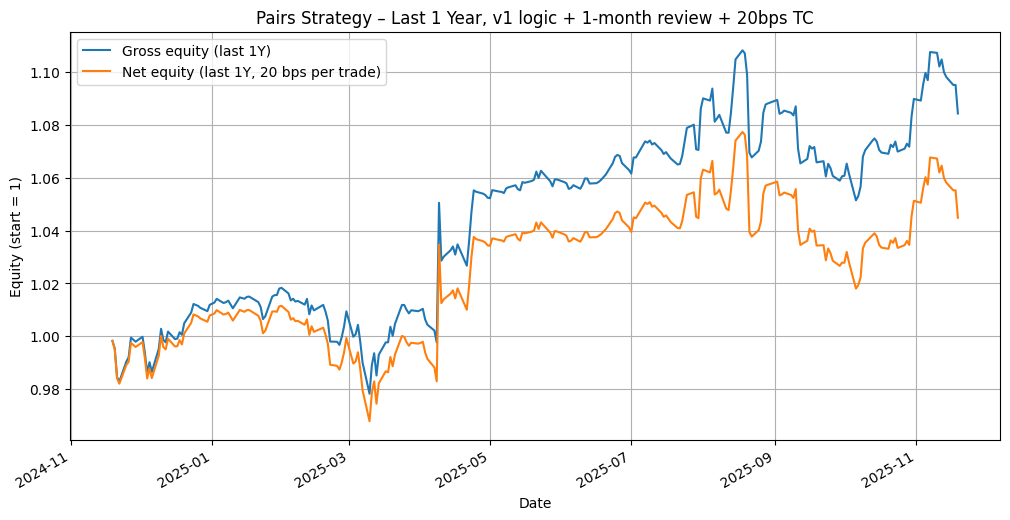

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# ASSUMPTIONS
# ==========================================================
# - You already have:
#     ohlcv    : DataFrame with ['date', 'Ticker', 'adj_close'] (or 'close')
#     top_pairs: DataFrame from your formation step with columns
#                ['y','x','alpha','beta',
#                 'formation_start','formation_end',
#                 'trading_start','trading_end','window_id', ...]
# ==========================================================

# ==========================================================
# 0. PRICE PANEL (LEVELS)
# ==========================================================
ohlcv = ohlcv.copy()
ohlcv['date'] = pd.to_datetime(ohlcv['date'])
ohlcv = ohlcv.sort_values('date')

px_all = (
    ohlcv
    .pivot_table(index='date', columns='ticker', values='adj_close')  # or 'close'
    .sort_index()
)

last_price_date = px_all.index.max()

# ==========================================================
# 1. PARAMETERS (V1 STYLE + TC)
# ==========================================================
min_length = 100     # minimum data points to bother trading
entry_z    = 2.0     # enter when |z| > 2
stop_z     = 3.0     # stop-loss when |z| >= 3
window_len = 30      # rolling window length (days) for z-score

short_exit_z = 0.5  # close SHORT when z < 0.75
long_exit_z  = -0.5  # close LONG when z > -0.5

tc_per_trade = 0.002  # 20 bps per unit change in position

# ==========================================================
# 2. ENRICH top_pairs WITH NEXT-WINDOW INFO & REVIEW DATE
# ==========================================================
top_pairs = top_pairs.copy()
top_pairs = top_pairs.sort_values(['window_id', 'adf_stat']).reset_index(drop=True)

# windows in chronological order
win_list = sorted(top_pairs['window_id'].unique())

# map window -> next window
next_map = {}
for i, w in enumerate(win_list):
    if i + 1 < len(win_list):
        next_map[w] = win_list[i + 1]
    else:
        next_map[w] = None

top_pairs['next_window_id'] = top_pairs['window_id'].map(next_map)

# set of (y,x) pairs per window
pairs_by_window = {
    w: set(zip(df_w['y'], df_w['x']))
    for w, df_w in top_pairs.groupby('window_id')
}

def is_in_next_window(row):
    nw = row['next_window_id']
    if nw is None:
        return False
    return (row['y'], row['x']) in pairs_by_window.get(nw, set())

top_pairs['in_next_window'] = top_pairs.apply(is_in_next_window, axis=1)

# review date = 1 month after original trading_end
top_pairs['review_date'] = top_pairs['trading_end'] + pd.DateOffset(months=1)

# extended trading end = review_date, capped by last available price date
top_pairs['trading_end_ext'] = top_pairs['review_date'].where(
    top_pairs['review_date'] <= last_price_date,
    last_price_date
)

# ==========================================================
# 3. BACKTEST HELPER: V1 LOGIC + REVIEW + 20bps TC
# ==========================================================
def backtest_pair_row_review_tc(row, px_panel):
    """
    Per-pair backtest:
      - Fixed z-score window_len (30)
      - Daily returns
      - 20 bps transaction cost per unit change in position
      - Trading window [trading_start, trading_end_ext]
      - From review_date onward, if pair is NOT in next formation's top list,
        positions are forced to flat.
    """
    y_tkr = row['y']
    x_tkr = row['x']
    alpha = row['alpha']
    beta  = row['beta']

    form_start    = row['formation_start']
    form_end      = row['formation_end']
    trade_start   = row['trading_start']
    trade_end     = row['trading_end']        # original 6m end (for info)
    trade_end_ext = row['trading_end_ext']    # up to +1m
    review_date   = row['review_date']
    in_next       = bool(row['in_next_window'])
    portfolio_id  = row['window_id']

    # check tickers exist
    if y_tkr not in px_panel.columns or x_tkr not in px_panel.columns:
        return None

    # prices from formation start through extended trading end
    px_win = px_panel.loc[form_start:trade_end_ext, [y_tkr, x_tkr]].dropna(how='all')
    if px_win.shape[0] < min_length:
        return None

    # log prices for spread
    log_y = np.log(px_win[y_tkr])
    log_x = np.log(px_win[x_tkr])

    spread = log_y - (alpha + beta * log_x)
    spread = spread.dropna()
    if spread.shape[0] < min_length:
        return None

    # rolling z-score with window_len = 30
    spread_mean = spread.rolling(window_len).mean()
    spread_std  = spread.rolling(window_len).std()
    z = (spread - spread_mean) / spread_std
    z = z.replace([np.inf, -np.inf], np.nan)

    # trading state
    position_signal = pd.Series(0.0, index=z.index)
    state = 0  # 0 flat, 1 long spread, -1 short spread

    for t, z_t in z.items():

        # invalid z -> flat
        if pd.isna(z_t):
            state = 0
            position_signal.loc[t] = state
            continue

        # never trade outside [trade_start, trade_end_ext]
        if t < trade_start or t > trade_end_ext:
            state = 0

        else:
            # after review date, if not in next window, must be flat
            if (not in_next) and (t >= review_date):
                state = 0
            else:
                if state == 0:
                    # ENTRY
                    if z_t > entry_z:
                        state = -1   # short spread
                    elif z_t < -entry_z:
                        state = 1    # long spread
                else:
                    # STOP LOSS
                    if abs(z_t) >= stop_z:
                        state = 0
                    else:
                        # ASYMMETRIC EXIT
                        if state == -1 and z_t < short_exit_z:
                            state = 0      # close short
                        elif state == 1 and z_t > long_exit_z:
                            state = 0      # close long

        position_signal.loc[t] = state

    # avoid lookahead: trade on yesterday's signal
    position = position_signal.shift(1).fillna(0)

    # daily returns for y and x
    ret_y = px_win[y_tkr].pct_change()
    ret_x = px_win[x_tkr].pct_change()
    spread_ret = (ret_y - beta * ret_x).reindex(position.index)

    # gross return before transaction costs
    gross_ret = position * spread_ret

    # turnover = |change in position|
    turnover = position.diff().abs().fillna(position.abs())
    fee = turnover * tc_per_trade

    net_ret = gross_ret - fee

    # restrict to extended trading window and clean up
    gross_ret = gross_ret.loc[trade_start:trade_end_ext].dropna()
    net_ret   = net_ret.loc[trade_start:trade_end_ext].dropna()

    if net_ret.empty:
        return None

    fee      = fee.loc[trade_start:trade_end_ext].reindex(net_ret.index).fillna(0.0)
    position = position.loc[trade_start:trade_end_ext].reindex(net_ret.index).fillna(0.0)

    df = pd.DataFrame({
        'gross_ret': gross_ret,
        'net_ret':   net_ret,
        'fee':       fee,
        'position':  position,
    })
    df['pair'] = f'{y_tkr}-{x_tkr}'
    df['portfolio'] = portfolio_id
    return df

# ==========================================================
# 4. DAILY RETURNS PER PAIR (FULL HISTORY)
# ==========================================================
pair_daily_list = []

for _, row in top_pairs.iterrows():
    df_pair = backtest_pair_row_review_tc(row, px_all)
    if df_pair is not None:
        pair_daily_list.append(df_pair)

if not pair_daily_list:
    raise ValueError("No pairs produced trades - check your selection / parameters.")

pair_daily = pd.concat(pair_daily_list)
pair_daily.index.name = 'date'   # index is date
# columns: ['gross_ret','net_ret','fee','position','pair','portfolio']

# Ensure datetime index & sorted
if not isinstance(pair_daily.index, pd.DatetimeIndex):
    pair_daily.index = pd.to_datetime(pair_daily.index)
pair_daily = pair_daily.sort_index()

# ==========================================================
# 5. RESTRICT TO LAST 1 YEAR (USE BOOLEAN MASK)
# ==========================================================
end_date = pair_daily.index.max()
start_1y = end_date - pd.DateOffset(years=1)

mask = (pair_daily.index >= start_1y) & (pair_daily.index <= end_date)
pair_daily_1y = pair_daily.loc[mask].copy()

if pair_daily_1y.empty:
    raise ValueError("No pair returns in the last 1 year – check dates / data.")

# ==========================================================
# 6. STRATEGY DAILY RETURNS (GROSS VS NET, LAST 1 YEAR)
# ==========================================================
strategy_daily_gross = (
    pair_daily_1y
    .groupby('date')['gross_ret']
    .mean()
    .sort_index()
)

strategy_daily_net = (
    pair_daily_1y
    .groupby('date')['net_ret']
    .mean()
    .sort_index()
)

fee_daily = (
    pair_daily_1y
    .groupby('date')['fee']
    .mean()
    .sort_index()
)

# Equity curves
equity_gross = (1.0 + strategy_daily_gross).cumprod()
equity_net   = (1.0 + strategy_daily_net).cumprod()

cum_return_gross = equity_gross - 1.0
cum_return_net   = equity_net - 1.0

final_cum_ret_gross = float(cum_return_gross.iloc[-1])
final_cum_ret_net   = float(cum_return_net.iloc[-1])
final_equity_gross  = float(equity_gross.iloc[-1])
final_equity_net    = float(equity_net.iloc[-1])
total_fee           = float(fee_daily.sum())

# basic stats (net, over last 1 year)
ann_mean_net = strategy_daily_net.mean() * 252
ann_vol_net  = strategy_daily_net.std() * np.sqrt(252)
sharpe_net   = ann_mean_net / ann_vol_net if ann_vol_net > 0 else np.nan

print(f"1Y window from {start_1y.date()} to {end_date.date()}")
print(f"Final cumulative return (gross, 1Y): {final_cum_ret_gross:.4f}")
print(f"Final equity gross (start = 1):      {final_equity_gross:.4f}")
print(f"Final cumulative return (net, 1Y):   {final_cum_ret_net:.4f}")
print(f"Final equity net (start = 1):        {final_equity_net:.4f}")
print(f"Total transaction fee (avg/day sum): {total_fee:.4f}")
print(f"Annualized mean (net, 1Y):           {ann_mean_net:.4f}")
print(f"Annualized vol  (net, 1Y):           {ann_vol_net:.4f}")
print(f"Sharpe (daily -> annual, net, 1Y):   {sharpe_net:.2f}")

# ==========================================================
# 7. PLOT EQUITY CURVES (GROSS VS NET, LAST 1 YEAR)
# ==========================================================
plt.figure(figsize=(12, 6))
equity_gross.plot(label='Gross equity (last 1Y)')
equity_net.plot(label='Net equity (last 1Y, 20 bps per trade)')
plt.title("Pairs Strategy – Last 1 Year, v1 logic + 1-month review + 20bps TC")
plt.ylabel("Equity (start = 1)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


#### BACKTEST WITHOUT GATEV AVG, WINDOW = HALF-LIFE PER PAIR + 20bps TC

Final cumulative return (gross): 0.1697
Final equity gross (start = 1):  1.1697
Final cumulative return (net):   -0.1527
Final equity net (start = 1):    0.8473
Total transaction fee (avg/day sum): 0.3225
Annualized mean (net):           -0.0152
Annualized vol  (net):           0.0811
Sharpe (daily -> annual, net):   -0.19


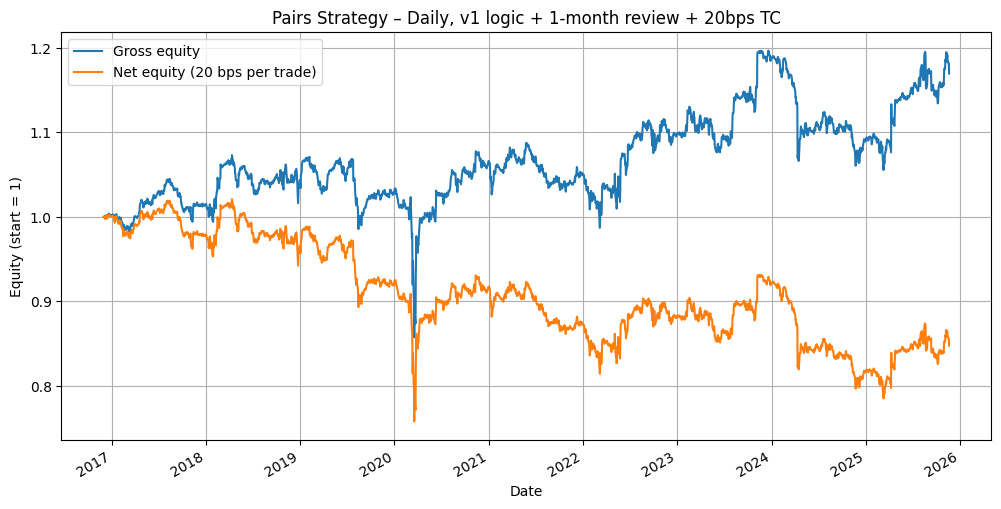

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 0. PRICE PANEL (LEVELS)
# ==========================================================
px_all = (
    ohlcv
    .pivot_table(index='date', columns='ticker', values='adj_close')  # or 'close'
    .sort_index()
)

last_price_date = px_all.index.max()

# ==========================================================
# 1. PARAMETERS (VERSION 1 STYLE + TC)
# ==========================================================
min_length = 100     # minimum data points to bother trading
entry_z    = 2.0     # enter when |z| > 2
stop_z     = 3.0     # stop-loss when |z| >= 3
window_len = 30      # rolling window length (days) for z-score

short_exit_z = 0.5  # close SHORT when z < 0.75
long_exit_z  = -0.5  # close LONG when z > -0.5

tc_per_trade = 0.002  # 20 bps per unit change in position

# ==========================================================
# 2. ENRICH top_pairs WITH NEXT-WINDOW INFO & REVIEW DATE
# ==========================================================
top_pairs = top_pairs.copy()
top_pairs = top_pairs.sort_values(['window_id', 'adf_stat']).reset_index(drop=True)

# windows in chronological order
win_list = sorted(top_pairs['window_id'].unique())

# map window -> next window
next_map = {}
for i, w in enumerate(win_list):
    if i + 1 < len(win_list):
        next_map[w] = win_list[i + 1]
    else:
        next_map[w] = None

top_pairs['next_window_id'] = top_pairs['window_id'].map(next_map)

# set of (y,x) pairs per window
pairs_by_window = {
    w: set(zip(df_w['y'], df_w['x']))
    for w, df_w in top_pairs.groupby('window_id')
}

def is_in_next_window(row):
    nw = row['next_window_id']
    if nw is None:
        return False
    return (row['y'], row['x']) in pairs_by_window.get(nw, set())

top_pairs['in_next_window'] = top_pairs.apply(is_in_next_window, axis=1)

# review date = 1 month after original trading_end
top_pairs['review_date'] = top_pairs['trading_end'] + pd.DateOffset(months=1)

# extended trading end = review_date, capped by last available price date
top_pairs['trading_end_ext'] = top_pairs['review_date'].where(
    top_pairs['review_date'] <= last_price_date,
    last_price_date
)

# ==========================================================
# 3. BACKTEST HELPER: V1 LOGIC + REVIEW + 20bps TC
# ==========================================================
def backtest_pair_row_review_tc(row, px_panel):
    """
    Per-pair backtest:
      - Fixed z-score window_len (30)
      - Daily returns
      - 20 bps transaction cost per unit change in position
      - Trading window [trading_start, trading_end_ext]
      - From review_date onward, if pair is NOT in next formation's top list,
        positions are forced to flat.
    """
    y_tkr = row['y']
    x_tkr = row['x']
    alpha = row['alpha']
    beta  = row['beta']

    form_start    = row['formation_start']
    form_end      = row['formation_end']
    trade_start   = row['trading_start']
    trade_end     = row['trading_end']        # original 6m end (for info)
    trade_end_ext = row['trading_end_ext']    # up to +1m
    review_date   = row['review_date']
    in_next       = bool(row['in_next_window'])
    portfolio_id  = row['window_id']

    # check tickers exist
    if y_tkr not in px_panel.columns or x_tkr not in px_panel.columns:
        return None

    # prices from formation start through extended trading end
    px_win = px_panel.loc[form_start:trade_end_ext, [y_tkr, x_tkr]].dropna(how='all')
    if px_win.shape[0] < min_length:
        return None

    # log prices for spread
    log_y = np.log(px_win[y_tkr])
    log_x = np.log(px_win[x_tkr])

    spread = log_y - (alpha + beta * log_x)
    spread = spread.dropna()
    if spread.shape[0] < min_length:
        return None

    # rolling z-score with window_len = 30
    spread_mean = spread.rolling(window_len).mean()
    spread_std  = spread.rolling(window_len).std()
    z = (spread - spread_mean) / spread_std
    z = z.replace([np.inf, -np.inf], np.nan)

    # trading state
    position_signal = pd.Series(0.0, index=z.index)
    state = 0  # 0 flat, 1 long spread, -1 short spread

    for t, z_t in z.items():

        # invalid z -> flat
        if pd.isna(z_t):
            state = 0
            position_signal.loc[t] = state
            continue

        # never trade outside [trade_start, trade_end_ext]
        if t < trade_start or t > trade_end_ext:
            state = 0

        else:
            # after review date, if not in next window, must be flat
            if (not in_next) and (t >= review_date):
                state = 0
            else:
                if state == 0:
                    # ENTRY
                    if z_t > entry_z:
                        state = -1   # short spread
                    elif z_t < -entry_z:
                        state = 1    # long spread
                else:
                    # STOP LOSS
                    if abs(z_t) >= stop_z:
                        state = 0
                    else:
                        # ASYMMETRIC EXIT
                        if state == -1 and z_t < short_exit_z:
                            state = 0      # close short
                        elif state == 1 and z_t > long_exit_z:
                            state = 0      # close long

        position_signal.loc[t] = state

    # avoid lookahead: trade on yesterday's signal
    position = position_signal.shift(1).fillna(0)

    # daily returns for y and x
    ret_y = px_win[y_tkr].pct_change()
    ret_x = px_win[x_tkr].pct_change()
    spread_ret = (ret_y - beta * ret_x).reindex(position.index)

    # gross return before transaction costs
    gross_ret = position * spread_ret

    # turnover = |change in position|
    turnover = position.diff().abs().fillna(position.abs())
    fee = turnover * tc_per_trade

    net_ret = gross_ret - fee

    # restrict to extended trading window and clean up
    gross_ret = gross_ret.loc[trade_start:trade_end_ext].dropna()
    net_ret   = net_ret.loc[trade_start:trade_end_ext].dropna()

    if net_ret.empty:
        return None

    fee      = fee.loc[trade_start:trade_end_ext].reindex(net_ret.index).fillna(0.0)
    position = position.loc[trade_start:trade_end_ext].reindex(net_ret.index).fillna(0.0)

    df = pd.DataFrame({
        'gross_ret': gross_ret,
        'net_ret':   net_ret,
        'fee':       fee,
        'position':  position,
    })
    df['pair'] = f'{y_tkr}-{x_tkr}'
    df['portfolio'] = portfolio_id
    return df

# ==========================================================
# 4. DAILY RETURNS PER PAIR (USING NEW BACKTEST FUNCTION)
# ==========================================================
pair_daily_list = []

for _, row in top_pairs.iterrows():
    df_pair = backtest_pair_row_review_tc(row, px_all)
    if df_pair is not None:
        pair_daily_list.append(df_pair)

if not pair_daily_list:
    raise ValueError("No pairs produced trades - check your selection / parameters.")

pair_daily = pd.concat(pair_daily_list)
pair_daily.index.name = 'date'   # index is date
# columns: ['gross_ret','net_ret','fee','position','pair','portfolio']

# ==========================================================
# 5. STRATEGY DAILY RETURNS (GROSS VS NET)
# ==========================================================
strategy_daily_gross = (
    pair_daily
    .groupby('date')['gross_ret']
    .mean()
    .sort_index()
)

strategy_daily_net = (
    pair_daily
    .groupby('date')['net_ret']
    .mean()
    .sort_index()
)

fee_daily = (
    pair_daily
    .groupby('date')['fee']
    .mean()
    .sort_index()
)

# Equity curves
equity_gross = (1.0 + strategy_daily_gross).cumprod()
equity_net   = (1.0 + strategy_daily_net).cumprod()

cum_return_gross = equity_gross - 1.0
cum_return_net   = equity_net - 1.0

final_cum_ret_gross = float(cum_return_gross.iloc[-1])
final_cum_ret_net   = float(cum_return_net.iloc[-1])
final_equity_gross  = float(equity_gross.iloc[-1])
final_equity_net    = float(equity_net.iloc[-1])
total_fee           = float(fee_daily.sum())

# basic stats (net)
ann_mean_net = strategy_daily_net.mean() * 252
ann_vol_net  = strategy_daily_net.std() * np.sqrt(252)
sharpe_net   = ann_mean_net / ann_vol_net if ann_vol_net > 0 else np.nan

print(f"Final cumulative return (gross): {final_cum_ret_gross:.4f}")
print(f"Final equity gross (start = 1):  {final_equity_gross:.4f}")
print(f"Final cumulative return (net):   {final_cum_ret_net:.4f}")
print(f"Final equity net (start = 1):    {final_equity_net:.4f}")
print(f"Total transaction fee (avg/day sum): {total_fee:.4f}")
print(f"Annualized mean (net):           {ann_mean_net:.4f}")
print(f"Annualized vol  (net):           {ann_vol_net:.4f}")
print(f"Sharpe (daily -> annual, net):   {sharpe_net:.2f}")

# ==========================================================
# 6. PLOT EQUITY CURVES (GROSS VS NET)
# ==========================================================
plt.figure(figsize=(12, 6))
equity_gross.plot(label='Gross equity')
equity_net.plot(label='Net equity (20 bps per trade)')
plt.title("Pairs Strategy – Daily, v1 logic + 1-month review + 20bps TC")
plt.ylabel("Equity (start = 1)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()
result_coin_roll_10 = equity_net.copy()

## Distance Method

### 1 - Fixed Window


Period 2023-06-01 → 2025-05-31 : using 108 tickers

Period 2023-07-01 → 2025-06-30 : using 108 tickers

Period 2023-08-01 → 2025-07-31 : using 108 tickers

Period 2023-09-01 → 2025-08-31 : using 108 tickers

Period 2023-10-01 → 2025-09-30 : using 108 tickers

Period 2023-11-01 → 2025-10-31 : using 108 tickers

=== Summary of selected pairs ===
          pair formation_start formation_end  rank  distance
0     PPL - SO      2023-06-01    2025-05-31     1  0.992384
1   EVRG - WEC      2023-06-01    2025-05-31     2  1.095062
2    DUK - REG      2023-06-01    2025-05-31     3  2.012348
3   ACN - EQIX      2023-06-01    2025-05-31     4  2.059202
4   ADSK - BLK      2023-06-01    2025-05-31     5  2.126066
5   EVRG - PNW      2023-07-01    2025-06-30     1  0.666587
6     DUK - SO      2023-07-01    2025-06-30     2  0.719873
7    ARE - IQV      2023-07-01    2025-06-30     3  1.484170
8    HSY - IPG      2023-07-01    2025-06-30     4  1.487467
9   ADSK - BLK      2023-07-01    2025-06-3

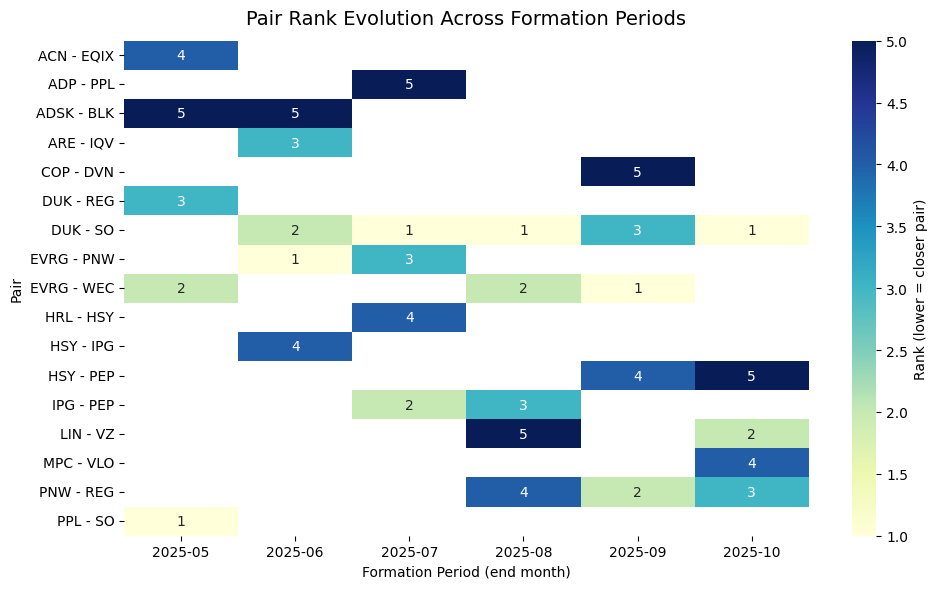

In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

prices = ohlcv.pivot(index='date', columns='ticker', values='close').sort_index()

def max_drawdown(equity):
    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max
    return drawdown.min(), drawdown

def normalize_name(name):
    name = name.lower()
    name = re.sub(r"\(.*?\)", "", name)
    name = re.sub(r"\b(class|series|ordinary|preference|shares?|adr|a|b|c|d)\b", "", name)
    name = re.sub(r"\b(inc|inc\.|corp|corp\.|corporation|co|co\.|ltd|ltd\.|plc|sa|nv|ag|group|holdings?)\b", "", name)
    name = re.sub(r"\s+", " ", name).strip().title()
    return name

def compute_cumulative_returns(series):
    "Return cumulative total-return series"
    returns = series.pct_change().fillna(0)
    cum = (1 + returns).cumprod()
    return cum

def pairwise_distance(df_prices):
    """
    Compute distance matrix on cumulative returns over the provided formation window.
    """
    cumrets = df_prices.apply(compute_cumulative_returns, axis=0)
    tickers = cumrets.columns

    n = len(tickers)
    dist = pd.DataFrame(np.nan, index=tickers, columns=tickers)
    for i, a in enumerate(tickers):
        for j in range(i+1, n):
            b = tickers[j]
            d = ((cumrets[a] - cumrets[b])**2).sum()
            dist.loc[a, b] = d
            dist.loc[b, a] = d
    np.fill_diagonal(dist.values, 0)

    return dist

def ols_alpha_beta_r2(px_f, X, Y, min_len=50):
    df = px_f[[X, Y]].dropna()
    if len(df) < min_len:
        return np.nan, np.nan, np.nan

    x = df[X]
    y = df[Y]

    yc = y - y.mean()
    xc = x - x.mean()
    denom = (yc ** 2).sum()
    if denom == 0:
        return np.nan, np.nan, np.nan

    beta = (yc * xc).sum() / denom
    alpha = x.mean() - beta * y.mean()

    x_hat = alpha + beta * y
    resid = x - x_hat
    ss_res = (resid ** 2).sum()
    ss_tot = ((x - x.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    return alpha, beta, r2

def pair_selection(start_date, end_date, top_k_pairs):
    window_prices = prices.loc[start_date:end_date].dropna(axis=1, how="any")
    print(f"Using {len(window_prices.columns)} tickers in the window [{start_date}, {end_date}]")

    # Compute distance matrix
    dist_matrix = pairwise_distance(window_prices)

    # Build all possible pairs
    pairs = []
    tickers = dist_matrix.columns
    for i, a in enumerate(tickers):
        for j in range(i + 1, len(tickers)):
            b = tickers[j]
            pairs.append((a, b, dist_matrix.loc[a, b]))

    df_pairs = pd.DataFrame(pairs, columns=["stock_A", "stock_B", "distance"]).sort_values("distance")

    # Select top pairs
    # Each stock can appear only once
    # Exclude pairs that belong to the same issuer (normalized company name)
    selected_pairs = []
    used_stocks = set()

    for _, row in df_pairs.iterrows():
        a, b = row["stock_A"], row["stock_B"]
        dis = row["distance"]
        name_a = normalize_name(ohlcv.loc[ohlcv["ticker"] == a, "name"].unique()[0])
        name_b = normalize_name(ohlcv.loc[ohlcv["ticker"] == b, "name"].unique()[0])

        if a not in used_stocks and b not in used_stocks and name_a != name_b:
            # selected_pairs.append(row)
            used_stocks.update([a, b])
            alpha, beta, r2 = ols_alpha_beta_r2(prices, a, b)
            selected_pairs.append({
                "X": a,
                "Y": b,
                "distance": dis,
                "alpha": alpha,
                "beta": beta,
                "R2": r2
            })
        if len(selected_pairs) >= top_k_pairs:
            break

    selected_pairs = pd.DataFrame(selected_pairs).reset_index(drop=True)

    filtered_pairs = selected_pairs[selected_pairs["R2"] > 0.6].reset_index(drop=True)

    print("Top pairs of Distance Method")
    print(selected_pairs.to_string(index=False))

    print("\nPairs with R^2 > 0.6:")
    print(filtered_pairs.to_string(index=False))

    return filtered_pairs


formation_months = 24      # trailing 24M
top_k_pairs = 5            # top pairs each formation
trade_month_starts = pd.date_range("2025-06-01", "2025-11-01", freq="MS")

all_period_pairs = []

for trade_start in trade_month_starts:
    # Define the formation window
    formation_end = trade_start - pd.Timedelta(days=1)
    formation_start = formation_end - pd.DateOffset(months=formation_months) + pd.Timedelta(days=1)

    # Extract price data for the formation window
    window_prices = prices.loc[formation_start:formation_end].dropna(axis=1, how="any")

    print(f"\nPeriod {formation_start.date()} → {formation_end.date()} : using {window_prices.shape[1]} tickers")

    # Compute distance matrix
    dist_matrix = pairwise_distance(window_prices)

    # Build all possible pairs
    pairs = []
    tickers = dist_matrix.columns
    for i, a in enumerate(tickers):
        for j in range(i + 1, len(tickers)):
            b = tickers[j]
            pairs.append((a, b, dist_matrix.loc[a, b]))
    df_pairs = pd.DataFrame(pairs, columns=["stock_A", "stock_B", "distance"]).sort_values("distance")

    # Select top pairs
    selected_pairs = []
    used_stocks = set()

    for _, row in df_pairs.iterrows():
        a, b = row["stock_A"], row["stock_B"]

        name_a = normalize_name(ohlcv.loc[ohlcv["ticker"] == a, "name"].unique()[0])
        name_b = normalize_name(ohlcv.loc[ohlcv["ticker"] == b, "name"].unique()[0])

        if a not in used_stocks and b not in used_stocks and name_a != name_b:
            selected_pairs.append(row)
            used_stocks.update([a, b])
        if len(selected_pairs) >= top_k_pairs:
            break

    selected_pairs = pd.DataFrame(selected_pairs)
    selected_pairs["rank"] = np.arange(1, len(selected_pairs) + 1)
    selected_pairs["formation_start"] = formation_start
    selected_pairs["formation_end"] = formation_end
    selected_pairs["period_label"] = formation_end.strftime("%Y-%m")
    all_period_pairs.append(selected_pairs)

# Combine all results into one DataFrame
all_pairs_df = pd.concat(all_period_pairs, ignore_index=True)
all_pairs_df["pair"] = all_pairs_df["stock_A"] + " - " + all_pairs_df["stock_B"]

print("\n=== Summary of selected pairs ===")
print(all_pairs_df[["pair", "formation_start", "formation_end", "rank", "distance"]])

# Pivot to pair × period matrix of ranks
rank_matrix = all_pairs_df.pivot(index="pair", columns="period_label", values="rank")

# Plot heatmap of pair ranks
plt.figure(figsize=(10, 6))
sns.heatmap(rank_matrix, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={"label": "Rank (lower = closer pair)"})
plt.title("Pair Rank Evolution Across Formation Periods", fontsize=14, pad=12)
plt.xlabel("Formation Period (end month)")
plt.ylabel("Pair")
plt.tight_layout()
plt.show()

Using 108 tickers in the window [2023-05-11, 2025-05-11]
Top pairs of Distance Method
   X    Y  distance      alpha      beta       R2
 DUK   SO  0.360700  39.210682  0.867751 0.868193
EVRG  WEC  0.934514  30.763304  0.335525 0.634878
 IPG  PEP  1.407319   3.400716  0.164843 0.589330
ADSK  BLK  2.004178 -12.710545  0.321814 0.828814
 PNW  PPL  2.094294  53.618426  0.876999 0.179507
 LIN  TSN  2.208044 452.596436 -2.818144 0.070837
EQIX  REG  2.251688 778.332137 -2.516160 0.014525
  ED  EXC  2.266067  44.759521  1.188898 0.688282
 AMP  RJF  2.427198 -47.154543  3.562296 0.956803
 EXR  IFF  2.513860 178.259293 -0.461859 0.092123
 CLX  MKC  2.658557  74.042479  1.063995 0.493333
 ECL SPGI  2.916640  86.622703  0.307201 0.802693
TSCO   VZ  2.950685  88.246753 -1.157380 0.322784
 BAX WYNN  2.975829  41.460940  0.167587 0.058056
 CRM  MAR  3.263588  35.768858  0.960609 0.650376

Pairs with R^2 > 0.6:
   X    Y  distance      alpha     beta       R2
 DUK   SO  0.360700  39.210682 0.867751 0.

,pair,Sharpe_gross,Sharpe_net,TotalReturn_gross,TotalReturn_net
2,ADSK-BLK,2.998646,2.826735,0.366699,0.339838
5,ECL-SPGI,1.874376,1.696006,0.111061,0.099989
6,CRM-MAR,0.573365,0.288463,0.045685,0.018682
0,DUK-SO,0.486029,-0.020688,0.016174,-0.001941
4,AMP-RJF,0.239164,0.174637,-0.001061,-0.016917
3,ED-EXC,-0.520406,-1.111278,-0.026332,-0.053236
1,EVRG-WEC,-0.741110,-1.274222,-0.026583,-0.045939


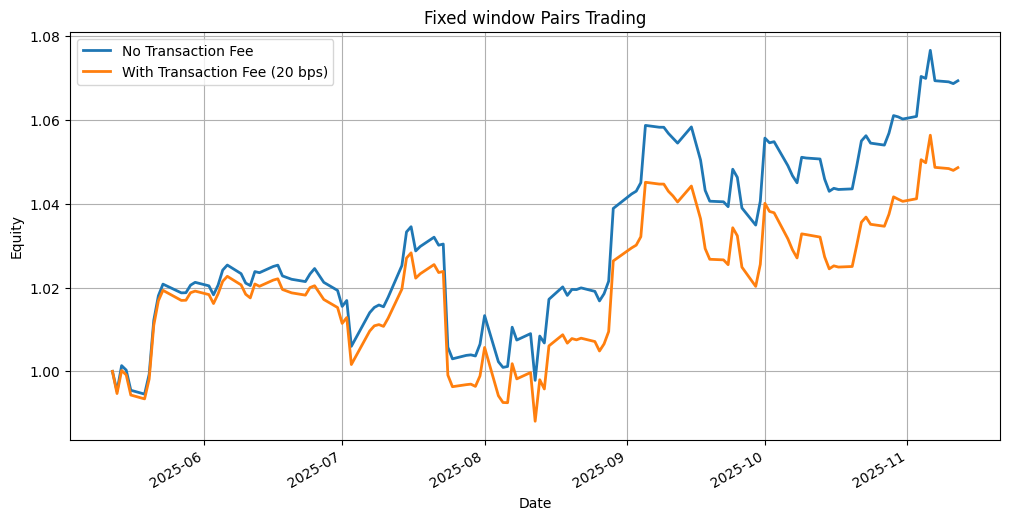

STOP LOSS EVENTS:


,date,pair,z_score,position_before
0,2025-10-01,DUK-SO,-3.077796,1
1,2025-08-04,EVRG-WEC,3.196549,-1
2,2025-09-30,EVRG-WEC,3.197157,-1
3,2025-07-10,ADSK-BLK,-4.241178,-1
4,2025-10-02,ED-EXC,-3.352992,1
5,2025-10-07,ED-EXC,-3.158983,1
6,2025-07-11,CRM-MAR,-3.172219,1
7,2025-08-12,CRM-MAR,-3.023106,1


===== Portfolio Performance Metrics =====
Sharpe Ratio:              1.2004
Maximum Drawdown:          -3.91%
Percentage Time in Market: 99.22%
Gross Gain:                0.2364
Gross Loss:                -0.1873
P/L Ratio:                 1.2624


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# PRICE PANEL & TRADING WINDOW (6M AFTER 24M FORMATION)
# ==========================================================

start_date = "2023-05-11"
end_date = "2025-05-11"
top_k_pairs = 15
filtered_pairs = pair_selection(start_date, end_date, top_k_pairs)
px = ohlcv.pivot(index="date", columns="ticker", values="close").sort_index()

form_start  = pd.Timestamp("2024-05-11")
form_end    = pd.Timestamp("2025-05-11")
trade_start = pd.Timestamp("2025-05-12")
trade_end   = pd.Timestamp("2025-11-12")

# Keep only prices between formation start and trading end
px_all = px.loc[(px.index >= form_start) & (px.index <= trade_end)]
top = filtered_pairs[["X", "Y", "alpha", "beta"]].reset_index(drop=True)

# All tickers involved in these pairs
I1_tickers = sorted(set(top["X"]).union(top["Y"]))
px_I1 = px_all[I1_tickers]

# Backtest only over the trading period
px_full = px_I1.loc[(px_I1.index >= form_start) & (px_I1.index <= trade_end)]
px_recent = px_I1.loc[(px_I1.index >= trade_start) & (px_I1.index <= trade_end)]

# ==========================================================
# BACKTEST PARAMETERS
# ==========================================================
window = 30       # z-score rolling window
min_length = 100   # minimum days to trade
results = []       # store results for each pair
equity_curves = {} # store equity curves
stop_events = []   # stop-loss logging
positions_dict = {}

# ==========================================================
# LOOP THROUGH EACH PAIR top pairs
# ==========================================================
for i, row in top.iterrows():

    X = row["X"]
    Y = row["Y"]
    alpha = row["alpha"]
    beta  = row["beta"]

    if X not in px_recent.columns or Y not in px_recent.columns:
        continue

    # Extract price series in trading period
    px_X = np.log(px_full[X])
    px_Y = np.log(px_full[Y])

    # Compute spread using formation-period OLS alpha, beta
    spread = px_X - (alpha + beta * px_Y)
    spread = spread.dropna()

    if len(spread) < min_length:
        continue

    # Rolling z-score (only within trading period)
    spread_mean = spread.rolling(window).mean()
    spread_std  = spread.rolling(window).std()
    z = (spread - spread_mean) / spread_std
    z = z.loc[z.index >= trade_start]
    # ======================================================
    # TRADING SIGNAL + 3-SIGMA STOP LOSS
    # ======================================================
    position = pd.Series(0, index=z.index)
    state = 0   # 0 = flat, 1 = long spread, -1 = short spread

    for t, z_t in z.items():

        if state == 0:
            if z_t > 2:
                state = -1
            elif z_t < -2:
                state = 1
        else:
            if abs(z_t) >= 3:
                stop_events.append({
                    "date": t,
                    "pair": f"{X}-{Y}",
                    "z_score": z_t,
                    "position_before": state
                })
                state = 0
            elif -0.5 < z_t < 0.5:
                state = 0

        position.loc[t] = state

    # Avoid lookahead bias
    position = position.shift(1).fillna(0)

    # ======================================================
    # COMPUTE STRATEGY RETURNS
    # ======================================================
    ret_X = px_recent[X].pct_change()
    ret_Y = px_recent[Y].pct_change()
    spread_ret = ret_X - beta * ret_Y
    spread_ret = spread_ret.reindex(position.index).fillna(0)

    strategy_ret_gross = position * spread_ret

    # --- transaction notional ---
    pos_change = position.diff().fillna(0).abs()

    fee_rate = 0.002
    transaction_fee = pos_change * fee_rate

    # net return
    strategy_ret_net = strategy_ret_gross - transaction_fee

    # equity curves
    equity_gross = (1 + strategy_ret_gross).cumprod()
    equity_net = (1 + strategy_ret_net).cumprod()

    pair_name = f"{X}-{Y}"
    positions_dict[pair_name] = position
    equity_curves[pair_name + "_gross"] = equity_gross
    equity_curves[pair_name + "_net"] = equity_net

    # sharpe
    sharpe_gross = strategy_ret_gross.mean() / strategy_ret_gross.std() * np.sqrt(252) if strategy_ret_gross.std() > 0 else np.nan
    sharpe_net = strategy_ret_net.mean() / strategy_ret_net.std() * np.sqrt(252) if strategy_ret_net.std() > 0 else np.nan

    results.append({
        "pair": pair_name,
        "Sharpe_gross": sharpe_gross,
        "Sharpe_net": sharpe_net,
        "TotalReturn_gross": equity_gross.iloc[-1] - 1,
        "TotalReturn_net": equity_net.iloc[-1] - 1
    })

# ==========================================================
# SHOW RESULTS SUMMARY TABLE
# ==========================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Sharpe_gross", ascending=False)

print("TOP STRATEGIES (6M Trading, Distance Pairs with R²>0.6, 3σ Stop-Loss):")
display(results_df.head(10))

# ==========================================================
# PORTFOLIO (WITH & WITHOUT TRANSACTION FEES)
# ==========================================================

# extract gross and net separately
gross_equities = {k:v for k,v in equity_curves.items() if k.endswith("_gross")}
net_equities   = {k:v for k,v in equity_curves.items() if k.endswith("_net")}

gross_aligned = pd.concat(gross_equities.values(), axis=1).ffill().bfill()
net_aligned   = pd.concat(net_equities.values(), axis=1).ffill().bfill()

portfolio_gross = gross_aligned.mean(axis=1)
portfolio_net   = net_aligned.mean(axis=1)

plt.figure(figsize=(12,6))
portfolio_gross.plot(label="No Transaction Fee", linewidth=2)
portfolio_net.plot(label=f"With Transaction Fee ({fee_rate*1e4:.0f} bps)", linewidth=2)

plt.title("Fixed window Pairs Trading")
plt.ylabel("Equity")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.show()

# Show all stop-loss events
stop_df = pd.DataFrame(stop_events)
print("STOP LOSS EVENTS:")
display(stop_df)

# Align and aggregate all positions
pos_aligned = pd.concat(positions_dict.values(), axis=1).fillna(0)

# Daily returns of portfolio
port_ret = portfolio_net.pct_change().dropna()

# Sharpe Ratio
sharpe = port_ret.mean() / port_ret.std() * np.sqrt(252)

mdd, dd_series = max_drawdown(portfolio_net)

# Percentage of Time in Market
time_in_mkt = (pos_aligned.abs().sum(axis=1) > 0).mean()

# Gross Gain / Gross Loss / P&L Ratio
gross_gain = port_ret[port_ret > 0].sum()
gross_loss = port_ret[port_ret < 0].sum()   # negative value
pl_ratio = gross_gain / abs(gross_loss) if gross_loss != 0 else np.nan

print("===== Portfolio Performance Metrics =====")
print(f"Sharpe Ratio:              {sharpe:.4f}")
print(f"Maximum Drawdown:          {mdd:.2%}")
print(f"Percentage Time in Market: {time_in_mkt:.2%}")
print(f"Gross Gain:                {gross_gain:.4f}")
print(f"Gross Loss:                {gross_loss:.4f}")
print(f"P/L Ratio:                 {pl_ratio:.4f}")

result_dis_fixed_06 = portfolio_net.copy()


### 2 - Rolling Window


=== MONTHLY REBALANCE ===
Formation: 2015-12-01 → 2016-11-30
Trading:   2016-12-01 → 2016-12-31
Using 102 tickers in the window [2015-12-01 00:00:00, 2016-11-30 00:00:00]
Top pairs of Distance Method
  X    Y  distance       alpha      beta       R2
 ED  WEC  0.075236   50.368399  0.416597 0.443821
ADP   GE  0.217352  147.620315  0.355272 0.110074
APD  LIN  0.231530  113.182552  0.432089 0.703989
 GD   GL  0.245131   28.204020  1.919101 0.568179
BLK   DD  0.245964  664.196113 -1.016184 0.000628
DUK  PNW  0.259137   53.478827  0.496939 0.098909
 SO   VZ  0.336476  108.649667 -0.937392 0.252303
HST  MAR  0.340305   15.944658  0.007798 0.041904
MKC  REG  0.341517  112.779989 -0.635102 0.119901
ECL  IPG  0.383292  115.431646  2.472249 0.095674
ACN PSKY  0.413134  356.200757 -3.454740 0.578301
ABT  LLY  0.416407   67.076735  0.075186 0.458390
APH CDNS  0.432155    8.309363  0.209530 0.797642
AMP   GM  0.459326 -100.059940  8.576695 0.355519
EMR  MMM  0.519905  105.906420 -0.175097 0.052067

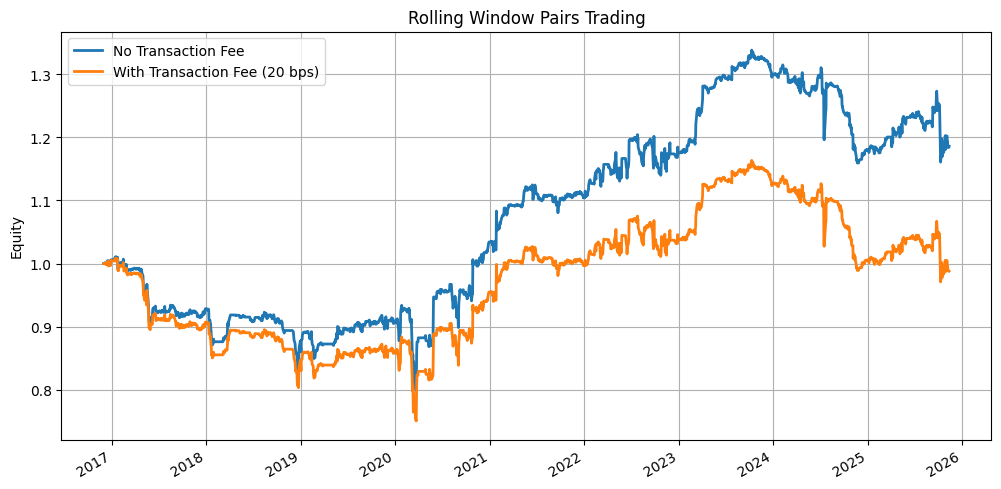

Sharpe (No Fee): 0.26039827339539
Sharpe (With Fee): 0.03159395465707171

Final Equity No Fee: 1.1858982889567333
Final Equity With Fee: 0.9879092252807685
Max Drawdown No Fee: -21.07%
Max Drawdown With Fee: -25.59%
Percentage of Time in the Market: 60.94%
STOP LOSS EVENTS:


,date,pair,z_score,position_before
0,2017-01-30,APD-LIN,-3.137685,1.0
1,2017-01-25,ADP-EMR,-3.022633,1.0
2,2017-08-29,EG-GD,-3.276027,1.0
3,2017-09-05,EG-GD,-3.603036,1.0
4,2017-09-07,EG-GD,-3.496284,1.0
...,...,...,...,...
58,2025-10-01,EVRG-WEC,3.085934,-1.0
59,2025-10-01,DUK-SO,-3.077796,1.0
60,2025-10-22,AMP-MAR,-3.045398,1.0
61,2025-11-05,AMP-MAR,-3.398690,1.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# PARAMETERS
# ==========================================================
formation_months = 12
trade_months = 1
top_k_pairs = 15
min_length = 30
window = 30
transaction_fee = 0.002  # 20 bps per trade

start_trade = pd.Timestamp("2016-12-01")
end_trade   = pd.Timestamp("2025-11-12")

# ==========================================================
# GLOBAL EQUITY SERIES (two versions)
# ==========================================================
portfolio_daily_equity_nofee = pd.Series(dtype=float)
portfolio_daily_equity_fee    = pd.Series(dtype=float)
portfolio_daily_equity_nofee.loc[start_trade] = 1.0
portfolio_daily_equity_fee.loc[start_trade]    = 1.0

# Dictionaries to track carry-over
prev_positions = {}
prev_px = {}
positions_dict = {}
stop_events = []

all_days = px.index[(px.index >= start_trade) & (px.index <= end_trade)]
rebalance_months = sorted(set([pd.Timestamp(d.year, d.month, 1) for d in all_days]))
rebalance_months = [d for d in rebalance_months if d >= start_trade]

# ==========================================================
# MONTHLY LOOP
# ==========================================================
for t0 in rebalance_months:

    form_start = t0 - pd.DateOffset(months=formation_months)
    form_end   = t0 - pd.Timedelta(days=1)

    trade_start = t0
    trade_end   = (t0 + pd.DateOffset(months=trade_months)) - pd.Timedelta(days=1)
    trade_end   = min(trade_end, end_trade)

    print(f"\n=== MONTHLY REBALANCE ===")
    print(f"Formation: {form_start.date()} → {form_end.date()}")
    print(f"Trading:   {trade_start.date()} → {trade_end.date()}")

    # Select pairs
    filtered_pairs = pair_selection(form_start, form_end, top_k_pairs)
    top_pairs = filtered_pairs[["X", "Y", "alpha", "beta"]].reset_index(drop=True)
    month_pairs = [f"{row['X']}-{row['Y']}" for _, row in top_pairs.iterrows()]

    # Price windows
    px_full = px.loc[(px.index >= form_start) & (px.index <= trade_end)]
    px_f = px.loc[(px.index >= form_start) & (px.index <= form_end)]
    px_tr = px.loc[(px.index >= trade_start) & (px.index <= trade_end)]
    if px_tr.empty:
        continue

    # DataFrames to collect daily returns for all pairs this month
    strat_ret_df_nofee = pd.DataFrame(index=px_tr.index)  # per-pair daily returns (no fee)
    strat_ret_df_fee   = pd.DataFrame(index=px_tr.index)  # per-pair daily returns (with fee)
    month_positions = {}  # end-of-month positions

    # Force-close prev positions that are not in new top list ON first trading day
    dropped_pairs = [p for p in list(prev_positions.keys()) if p not in month_pairs]
    for pair in dropped_pairs:
        # close at first trading price if available
        t_first = px_tr.index[0]
        X, Y = pair.split('-')
        if (X in px.columns) and (Y in px.columns):
            beta = prev_px[pair]['beta']
            px_X_first = px.loc[t_first, X]
            px_Y_first = px.loc[t_first, Y]
            # realized return on the carried position (relative to original X price)
            pos = prev_positions[pair]
            ret = pos * ((px_X_first - prev_px[pair]['X']) - beta * (px_Y_first - prev_px[pair]['Y'])) / prev_px[pair]['X']
            # add a daily return series of this closed position
            ser = pd.Series(0.0, index=px_tr.index)
            ser.iloc[0] = ret  # realize on first day
            strat_ret_df_nofee[f"{pair}_closed"] = ser
            # apply fee for closing if pos != 0
            fee_ser = pd.Series(0.0, index=px_tr.index)
            fee_ser.iloc[0] = transaction_fee * abs(pos)
            strat_ret_df_fee[f"{pair}_closed"] = ser - fee_ser
        # remove from prev_
        prev_positions.pop(pair, None)
        prev_px.pop(pair, None)

    # Iterate each selected pair and compute daily strat returns (aligned to px_tr index)
    for i, row in top_pairs.iterrows():
        X, Y = row["X"], row["Y"]
        alpha, beta = row["alpha"], row["beta"]
        pair_name = f"{X}-{Y}"

        # require these columns exist
        if (X not in px_full.columns) or (Y not in px_full.columns):
            continue

        # compute spread on px_full
        px_X_full = np.log(px_full[X])
        px_Y_full = np.log(px_full[Y])
        spread = px_X_full - (beta * px_Y_full)
        spread = spread.dropna()

        # rolling z-score
        spread_mean = spread.rolling(window).mean()
        spread_std  = spread.rolling(window).std()
        z = (spread - spread_mean) / spread_std
        z = z.loc[z.index >= trade_start]

        # carry-over state if exists
        state = prev_positions.get(pair_name, 0)

        # signal series (aligned to z.index)
        position = pd.Series(0, index=z.index)
        for t, z_t in z.items():
            if state == 0:
                if z_t > 2:
                    state = -1
                elif z_t < -2:
                    state = 1
            else:
                if abs(z_t) >= 3:
                    stop_events.append({
                    "date": t,
                    "pair": f"{X}-{Y}",
                    "z_score": z_t,
                    "position_before": state
                })
                    state = 0
                if -0.5 < z_t < 0.5:
                    state = 0
            position.loc[t] = state
        # shift to avoid lookahead: trade executed next day based on signal at t
        position = position.shift(1).reindex(px_tr.index).fillna(0).astype(float)
        positions_dict[pair_name] = position

        # Compute daily returns for X and Y in trading window
        px_X_tr = px_tr[X]
        px_Y_tr = px_tr[Y]
        ret_X = px_X_tr.pct_change().fillna(0)
        ret_Y = px_Y_tr.pct_change().fillna(0)

        # spread return per day (strategy return per unit position)
        spread_ret = ret_X - beta * ret_Y
        spread_ret = spread_ret.reindex(px_tr.index).fillna(0)

        # strat return (no fee)
        strat_ret_nofee = position * spread_ret

        # transaction fee cost: when position changes (abs delta) we charge fee per unit
        pos_change = position.diff().fillna(position.abs())
        fee_cost = transaction_fee * pos_change.abs()

        strat_ret_fee = strat_ret_nofee - fee_cost

        # store in df
        strat_ret_df_nofee[pair_name] = strat_ret_nofee
        strat_ret_df_fee[pair_name]   = strat_ret_fee

        # save carry-over / last px info for next month
        month_positions[pair_name] = position.iloc[-1]
        prev_px[pair_name] = {'X': px_X_tr.iloc[-1], 'Y': px_Y_tr.iloc[-1], 'beta': beta}

    # If no pair returns, skip
    if strat_ret_df_nofee.empty:
        continue

    #average daily returns across pairs, then cumprod across days
    daily_portfolio_ret_nofee = strat_ret_df_nofee.mean(axis=1)
    daily_portfolio_ret_fee   = strat_ret_df_fee.mean(axis=1) if not strat_ret_df_fee.empty else daily_portfolio_ret_nofee - 0.0

    # create monthly equity series (relative, starting at 1)
    month_portfolio_nofee = (1 + daily_portfolio_ret_nofee).cumprod()
    month_portfolio_fee   = (1 + daily_portfolio_ret_fee).cumprod()

    # Align first day with previous total portfolio equity (rebase)
    if month_portfolio_nofee.index[0] not in portfolio_daily_equity_nofee.index:
        base_nofee = portfolio_daily_equity_nofee.iloc[-1]
        base_fee   = portfolio_daily_equity_fee.iloc[-1]
        month_portfolio_nofee = month_portfolio_nofee / month_portfolio_nofee.iloc[0] * base_nofee
        month_portfolio_fee   = month_portfolio_fee   / month_portfolio_fee.iloc[0]   * base_fee

    # Append monthly equity
    portfolio_daily_equity_nofee = pd.concat([portfolio_daily_equity_nofee, month_portfolio_nofee[1:]])
    portfolio_daily_equity_fee   = pd.concat([portfolio_daily_equity_fee,   month_portfolio_fee[1:]])

    # Update carry-over positions for next month
    prev_positions = month_positions.copy()

# Force-close any remaining positions on last available day
if prev_positions:
    last_day = portfolio_daily_equity_nofee.index[-1]
    close_ret_list = []
    close_fee_list = []
    for pair, pos in prev_positions.items():
        X, Y = pair.split('-')
        if (X in px.columns) and (Y in px.columns):
            beta = prev_px[pair]['beta']
            px_X_last = px.loc[last_day, X]
            px_Y_last = px.loc[last_day, Y]
            ret = pos * ((px_X_last - prev_px[pair]['X']) - beta * (px_Y_last - prev_px[pair]['Y'])) / prev_px[pair]['X']
            close_ret_list.append(ret)
            close_fee_list.append(transaction_fee * abs(pos))
    final_ret_nofee = sum(close_ret_list) if close_ret_list else 0.0
    final_ret_fee   = final_ret_nofee - sum(close_fee_list) if close_fee_list else final_ret_nofee
    portfolio_daily_equity_nofee.iloc[-1] *= (1 + final_ret_nofee)
    portfolio_daily_equity_fee.iloc[-1] *= (1 + final_ret_fee)


# PLOT FINAL EQUITY (comparison)
plt.figure(figsize=(12,6))
portfolio_daily_equity_nofee.plot(label="No Transaction Fee", linewidth=2)
portfolio_daily_equity_fee.plot(label=f"With Transaction Fee ({transaction_fee*1e4:.0f} bps)", linewidth=2)
plt.title("Rolling Window Pairs Trading")
plt.ylabel("Equity")
plt.grid(True)
plt.legend()
plt.show()

# Performance metrics
daily_ret_nofee = portfolio_daily_equity_nofee.pct_change().dropna()
daily_ret_fee   = portfolio_daily_equity_fee.pct_change().dropna()
sharpe_nofee = (daily_ret_nofee.mean() / daily_ret_nofee.std()) * np.sqrt(252) if not daily_ret_nofee.empty else np.nan
sharpe_fee   = (daily_ret_fee.mean()   / daily_ret_fee.std())   * np.sqrt(252) if not daily_ret_fee.empty else np.nan

print("Sharpe (No Fee):", sharpe_nofee)
print("Sharpe (With Fee):", sharpe_fee)
print("\nFinal Equity No Fee:", portfolio_daily_equity_nofee.iloc[-1])
print("Final Equity With Fee:", portfolio_daily_equity_fee.iloc[-1])

mdd_gross, _ = max_drawdown(portfolio_daily_equity_nofee)
print(f"Max Drawdown No Fee: {mdd_gross:.2%}")

mdd_value, _ = max_drawdown(portfolio_daily_equity_fee)
print(f"Max Drawdown With Fee: {mdd_value:.2%}")

# Align and aggregate all positions
pos_aligned = pd.concat(positions_dict.values(), axis=1).fillna(0)

in_market = (pos_aligned.abs().sum(axis=1) > 0).astype(int)

pct_in_market = in_market.mean()
print(f"Percentage of Time in the Market: {pct_in_market:.2%}")

stop_df = pd.DataFrame(stop_events)
print("STOP LOSS EVENTS:")
display(stop_df)
result_dis_roll_10 = portfolio_daily_equity_fee.copy()

## Correlation Method

### 1 - Fixed Window

C:\Users\zhyim\AppData\Local\Temp\ipykernel_34212\1693408719.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_f = px_f.pct_change().dropna(how="all")  # daily returns in formation window


Pearson Top-30:
 ticker_A ticker_B     corr
     DAL      UAL 0.906452
     MPC      VLO 0.897740
     APA      DVN 0.861948
    EVRG      PPL 0.844645
     DUK       SO 0.827360
     AMP      RJF 0.820163
     BAC      TFC 0.810109
     DLR     EQIX 0.791235
     VTR     WELL 0.790962
     COP      HAL 0.789625
      ED      WEC 0.789313
    CTRA      EQT 0.736705
     HST      MAR 0.730866
     BLK     SPGI 0.704979
     EXC      PNW 0.697354
     APH     CDNS 0.693304
      DD      EMR 0.692614
     EXR      REG 0.685589
     ADP      LIN 0.684766
     CPB      PEP 0.670291
     BKR      OKE 0.669983
     AFL       GL 0.633624
   GOOGL     META 0.616711
     JBL     NXPI 0.613330
    HOOD      LYV 0.605225
      CF      MOS 0.596654
    ADSK      CRM 0.589217
    CARR     GNRC 0.542910
     ARE      LOW 0.541782
     CLX      MKC 0.541541

Spearman Top-30:
 ticker_A ticker_B     corr
     DAL      UAL 0.847566
     MPC      VLO 0.843244
     DUK       SO 0.835282
     APA      DVN 0

,pair,Sharpe,TotalReturn,LastEquity
2,APA-DVN,2.204267,0.137643,1.137643
10,BLK-SPGI,0.997333,0.063101,1.063101
1,MPC-VLO,0.361362,0.006129,1.006129
15,HOOD-LYV,0.267919,0.017346,1.017346
5,AMP-RJF,0.195831,0.005240,1.005240
13,BKR-OKE,-0.178359,-0.005373,0.994627
0,DAL-UAL,-0.186122,-0.004692,0.995308
7,DLR-EQIX,-0.507680,-0.009226,0.990774
12,CPB-PEP,-0.633767,-0.024744,0.975256
9,COP-HAL,-0.833874,-0.043182,0.956818


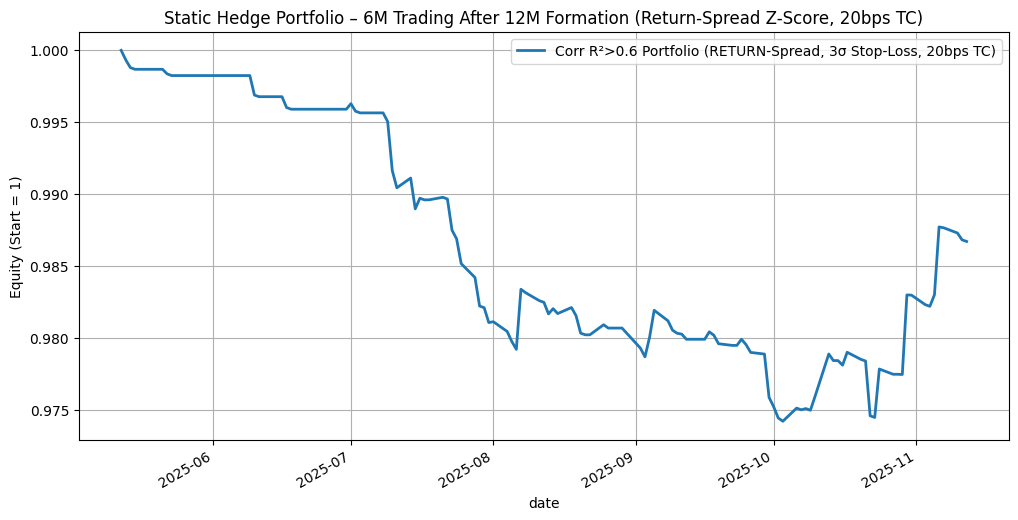

STOP LOSS EVENTS:


,date,pair,z_score,position_before
0,2025-08-07,APA-DVN,4.145063,1
1,2025-07-29,AFL-GL,-3.383482,1
2,2025-07-10,ADSK-CRM,-4.710463,1


==== STOP LOSS EVENTS ====


,date,pair,z_score,position_before
0,2025-08-07,APA-DVN,4.145063,1
1,2025-07-29,AFL-GL,-3.383482,1
2,2025-07-10,ADSK-CRM,-4.710463,1


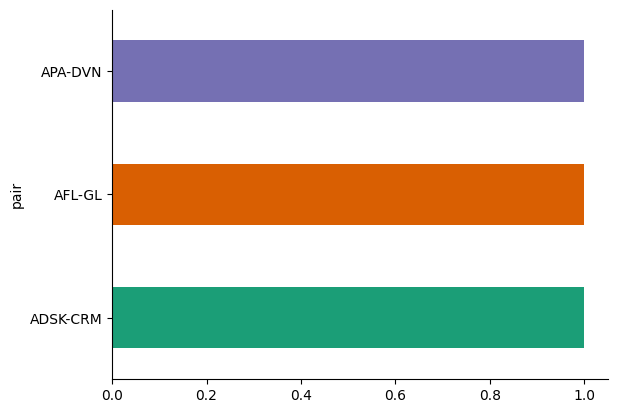

Removed pairs (stop_count > 4):


,pair,stop_count



Remaining pairs to keep:


,X,Y,alpha,beta,pair,stop_count
0,DAL,UAL,25.911407,0.359162,DAL-UAL,0.0
1,MPC,VLO,12.323287,1.052194,MPC-VLO,0.0
2,APA,DVN,-3.877582,0.702022,APA-DVN,1.0
3,EVRG,PPL,-3.299917,1.993643,EVRG-PPL,0.0
4,DUK,SO,-3.945610,1.349239,DUK-SO,0.0
5,AMP,RJF,126.609960,2.587397,AMP-RJF,0.0
6,BAC,TFC,10.004108,0.774114,BAC-TFC,0.0
7,DLR,EQIX,-2.214195,0.189627,DLR-EQIX,0.0
8,VTR,WELL,12.818653,0.366594,VTR-WELL,0.0
9,COP,HAL,52.533992,1.719998,COP-HAL,0.0


TOP STRATEGIES (Filtered Pairs Only, Corr R²>0.6, RETURN-Spread, 6M Trading, 20bps TC):


,pair,Sharpe,TotalReturn,LastEquity
2,APA-DVN,2.204267,0.137643,1.137643
10,BLK-SPGI,0.997333,0.063101,1.063101
1,MPC-VLO,0.361362,0.006129,1.006129
15,HOOD-LYV,0.267919,0.017346,1.017346
5,AMP-RJF,0.195831,0.005240,1.005240
13,BKR-OKE,-0.178359,-0.005373,0.994627
0,DAL-UAL,-0.186122,-0.004692,0.995308
7,DLR-EQIX,-0.507680,-0.009226,0.990774
12,CPB-PEP,-0.633767,-0.024744,0.975256
9,COP-HAL,-0.833874,-0.043182,0.956818


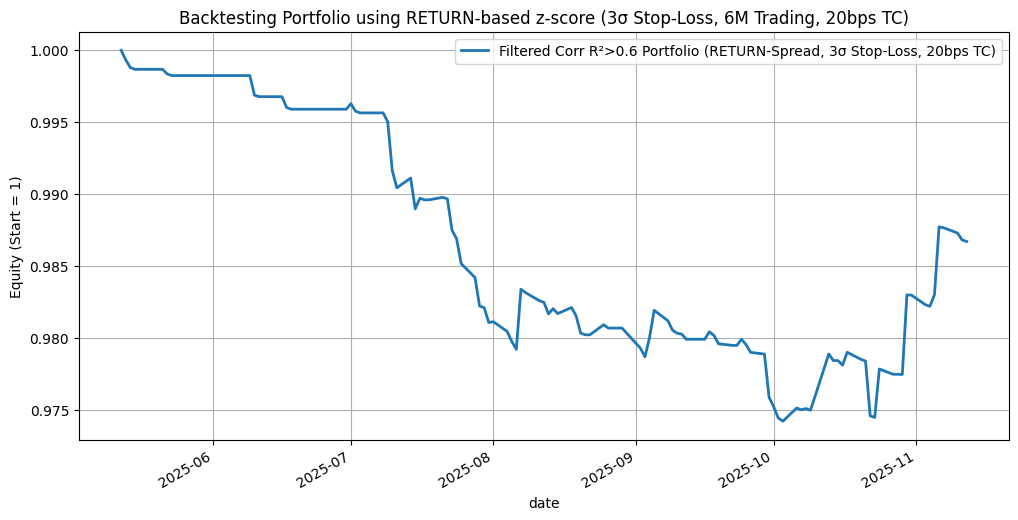


STOP LOSS EVENTS (Filtered Pairs Only):


,date,pair,z_score,position_before
0,2025-08-07,APA-DVN,4.145063,1
1,2025-07-29,AFL-GL,-3.383482,1
2,2025-07-10,ADSK-CRM,-4.710463,1


ALL PAIRS (Filtered Corr R²>0.6, 6M Trading, RETURN-Spread, 20bps TC):


,pair,Sharpe,TotalReturn,LastEquity
0,APA-DVN,2.204267,0.137643,1.137643
1,BLK-SPGI,0.997333,0.063101,1.063101
2,MPC-VLO,0.361362,0.006129,1.006129
3,HOOD-LYV,0.267919,0.017346,1.017346
4,AMP-RJF,0.195831,0.005240,1.005240
5,BKR-OKE,-0.178359,-0.005373,0.994627
6,DAL-UAL,-0.186122,-0.004692,0.995308
7,DLR-EQIX,-0.507680,-0.009226,0.990774
8,CPB-PEP,-0.633767,-0.024744,0.975256
9,COP-HAL,-0.833874,-0.043182,0.956818


In [ ]:
import re
import numpy as np
import pandas as pd
# --- Build price/volume matrices and define formation/trading windows ---
# Use adjusted close for returns
px  = (ohlcv.pivot(index="date", columns="ticker", values="adj_close").sort_index())
vol = (ohlcv.pivot(index="date", columns="ticker", values="volume").reindex(px.index))

# Fixed-window example (12M formation, 6M trading)
form_start  = pd.Timestamp("2024-05-11")
form_end    = pd.Timestamp("2025-05-11")
trade_start = pd.Timestamp("2025-05-11")
trade_end   = pd.Timestamp("2025-11-11")

# Formation / trading slices
px_f  = px.loc[(px.index >= form_start) & (px.index <= form_end)]
vol_f = vol.loc[px_f.index]
ret_f = px_f.pct_change().dropna(how="all")  # daily returns in formation window
px_t  = px.loc[(px.index >= trade_start) & (px.index <= trade_end)]


# Average daily dollar volume (formation window)
adv_f = (px_f * vol_f).mean().rename("ADV").dropna()

# 1) Normalize issuer name (remove "Class/Series/(...)" parts and company suffixes)
def issuer_key(name: str) -> str:
    s = (name or "").lower()
    s = re.sub(r"\(.*?\)", " ", s)
    s = re.sub(r"\b(class|cl|series)\b\s*[a-z0-9\-]*", " ", s)
    s = re.sub(r"\b(incorporated|inc|corp|corporation|company|co|plc|ltd|limited|sa|nv|ag)\b\.?", " ", s)
    s = re.sub(r"[^a-z0-9]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

meta = (ohlcv.drop_duplicates("ticker")[["ticker","name","GICS Sector","GICS Sub-Industry"]]
              .assign(issuer=lambda d: d["name"].map(issuer_key)))
meta["ADV_form"] = meta["ticker"].map(adv_f)

# Keep the most liquid share class per issuer during formation
keep_one = (meta.sort_values("ADV_form", ascending=False)
                .dropna(subset=["ADV_form"])
                .drop_duplicates(subset=["issuer"]))["ticker"].tolist()

# Rebuild formation/trading matrices using the deduplicated ticker list
px_f  = px_f[px_f.columns.intersection(keep_one)]
ret_f = ret_f[ret_f.columns.intersection(keep_one)]
px_t  = px_t[px_t.columns.intersection(keep_one)]

issuer_map = meta.set_index("ticker")["issuer"].to_dict()

# 2) Select Top-30 Pearson / Spearman pairs; enforce: non-overlapping + different issuers
def top_k_pairs_by_corr(ret_df, k=30, method="pearson", enforce_disjoint=True,
                        use_abs=False, issuer_map=None):
    C = ret_df.corr(method=method)
    pairs = []
    cols = C.columns.tolist()
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            a, b = cols[i], cols[j]
            rho = C.iat[i, j]
            if np.isnan(rho) or rho <= 0:
                continue
            if issuer_map and issuer_map.get(a)==issuer_map.get(b):
                continue
            score = abs(rho) if use_abs else rho
            pairs.append((a, b, rho, score))
    pairs.sort(key=lambda x: -x[3])

    chosen, used = [], set()
    for a,b,r,_ in pairs:
        if enforce_disjoint and (a in used or b in used):
            continue
        chosen.append((a,b,r))
        used.add(a); used.add(b)
        if len(chosen) >= k: break

    return pd.DataFrame(chosen, columns=["ticker_A","ticker_B","corr"])

pearson_top30  = top_k_pairs_by_corr(ret_f, k=30, method="pearson",
                                     enforce_disjoint=True, use_abs=False,
                                     issuer_map=issuer_map)
spearman_top30 = top_k_pairs_by_corr(ret_f, k=30, method="spearman",
                                     enforce_disjoint=True, use_abs=False,
                                     issuer_map=issuer_map)

print("Pearson Top-30:\n", pearson_top30.to_string(index=False))
print("\nSpearman Top-30:\n", spearman_top30.to_string(index=False))

# Quick checks: issuers differ and no overlap
assert all(issuer_map[a]!=issuer_map[b] for a,b,_ in pearson_top30.to_records(index=False))
assert pearson_top30[["ticker_A","ticker_B"]].stack().nunique()==60

def ols_alpha_beta_r2(px_f, X, Y, min_len=50):
    df = px_f[[X, Y]].dropna()
    if len(df) < min_len:
        return np.nan, np.nan, np.nan

    x = df[X]
    y = df[Y]

    yc = y - y.mean()
    xc = x - x.mean()
    denom = (yc ** 2).sum()
    if denom == 0:
        return np.nan, np.nan, np.nan

    beta = (yc * xc).sum() / denom
    alpha = x.mean() - beta * y.mean()

    x_hat = alpha + beta * y
    resid = x - x_hat
    ss_res = (resid ** 2).sum()
    ss_tot = ((x - x.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    return alpha, beta, r2

rows = []
for _, row in pearson_top30.iterrows():
    X = row["ticker_A"]
    Y = row["ticker_B"]
    corr = row["corr"]
    alpha, beta, r2 = ols_alpha_beta_r2(px_f, X, Y)
    rows.append({
        "X": X,
        "Y": Y,
        "corr": corr,
        "alpha": alpha,
        "beta": beta,
        "R2": r2
    })

top30_fit = pd.DataFrame(rows).dropna(subset=["R2"])

# Only R² > 0.6 pairs
filtered_pairs = top30_fit[top30_fit["R2"] > 0.6].reset_index(drop=True)

print("Pearson Top-30 with OLS fit:")
print(top30_fit.to_string(index=False))

print("\nPairs with R^2 > 0.6:")
print(filtered_pairs.to_string(index=False))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# PRICE PANEL & TRADING / FORMATION WINDOWS
# ==========================================================
px = ohlcv.pivot(index="date", columns="ticker", values="close").sort_index()

form_start  = pd.Timestamp("2024-05-11")
form_end    = pd.Timestamp("2025-05-11")
trade_start = pd.Timestamp("2025-05-12")   # trading starts after formation ends
trade_end   = pd.Timestamp("2025-11-12")

# Keep only prices between formation start and trading end
px_all = px.loc[(px.index >= form_start) & (px.index <= trade_end)]

# Daily returns over the same span (for return-based spread)
ret_all = px_all.pct_change().dropna(how="all")

# Pairs selected by correlation method with R² > 0.6 (from previous cell)
top30 = filtered_pairs[["X", "Y", "alpha", "beta"]].reset_index(drop=True)

# All tickers involved in these pairs
I1_tickers = sorted(set(top30["X"]).union(top30["Y"]))

px_I1  = px_all[I1_tickers]
ret_I1 = ret_all[I1_tickers]

# ==========================================================
# BACKTEST PARAMETERS
# ==========================================================
window     = 60        # rolling window for z-score on RETURN spread
min_length = 100       # minimum trading days for a pair
tc_rate    = 0.002     # 20 bps transaction cost per one-way trade

results       = []     # store results for each pair
equity_curves = {}     # store equity curves
stop_events   = []     # stop-loss logging

# ==========================================================
# LOOP THROUGH EACH PAIR IN top30 (CORR + R²>0.6)
# ==========================================================
for i, row in top30.iterrows():

    X     = row["X"]
    Y     = row["Y"]
    beta  = row["beta"]
    alpha = row["alpha"]  # not used in return spread, kept for reference

    if X not in ret_I1.columns or Y not in ret_I1.columns:
        continue

    # Full return history for the pair over formation + trading
    pair_ret_full = ret_I1[[X, Y]].dropna()

    # Only trading-period part, used to check length
    pair_ret_trade = pair_ret_full.loc[(pair_ret_full.index >= trade_start) &
                                       (pair_ret_full.index <= trade_end)]
    if len(pair_ret_trade) < min_length:
        continue

    ret_X_full = pair_ret_full[X]
    ret_Y_full = pair_ret_full[Y]

    # ------------------------------------------------------
    # Return-based spread on full history, then z-score
    # ------------------------------------------------------
    # spread_ret_t = r_X,t - beta * r_Y,t
    spread_ret_full = ret_X_full - beta * ret_Y_full

    spread_mean_full = spread_ret_full.rolling(window).mean()
    spread_std_full  = spread_ret_full.rolling(window).std()
    z_full = (spread_ret_full - spread_mean_full) / spread_std_full

    # Restrict z-score and spread returns to the trading window
    z = z_full.loc[(z_full.index >= trade_start) & (z_full.index <= trade_end)].dropna()
    spread_ret = spread_ret_full.reindex(z.index)

    # ======================================================
    # TRADING SIGNAL + 3-SIGMA STOP LOSS (TRADING PERIOD ONLY)
    # ======================================================
    position = pd.Series(0, index=z.index)  # +1 long spread, -1 short spread, 0 flat
    state    = 0                            # 0=flat, 1=long spread, -1=short spread

    for t, z_t in z.items():
        if state == 0:
            # Enter when |z| > 2
            if z_t > 2:
                state = -1  # short spread (short X, long Y)
            elif z_t < -2:
                state = 1   # long spread (long X, short Y)
        else:
            # Hard stop-loss when |z| >= 3
            if abs(z_t) >= 3:
                stop_events.append({
                    "date": t,
                    "pair": f"{X}-{Y}",
                    "z_score": z_t,
                    "position_before": state
                })
                state = 0
            # Exit when z reverts inside (-2, 2)
            elif -2 < z_t < 2:
                state = 0

        position.loc[t] = state

    # Avoid look-ahead bias: today's signal applies to next day's return
    position = position.shift(1).fillna(0)

    # ---------- transaction costs ----------
    turnover = position.diff().abs()
    if len(turnover) > 0:
        turnover.iloc[0] = abs(position.iloc[0])  # first day opening trade
    tc_ret = turnover * tc_rate

    # Strategy daily return (net of transaction cost) and equity curve
    gross_ret    = position * spread_ret
    strategy_ret = gross_ret - tc_ret
    equity       = (1 + strategy_ret).cumprod()

    pair_name = f"{X}-{Y}"
    equity_curves[pair_name] = equity

    sharpe = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252) if strategy_ret.std() > 0 else np.nan
    total_return = equity.iloc[-1] - 1

    results.append({
        "pair":        pair_name,
        "Sharpe":      sharpe,
        "TotalReturn": total_return,
        "LastEquity":  equity.iloc[-1]
    })

# ==========================================================
# SHOW RESULTS SUMMARY TABLE
# ==========================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Sharpe", ascending=False)

print("TOP STRATEGIES (6M Trading, Corr Pairs with R²>0.6, RETURN-Spread, 3σ Stop-Loss, 20bps TC):")
display(results_df.head(10))

# ==========================================================
# PORTFOLIO EQUITY CURVE (AVERAGE OF ALL PAIRS)
# ==========================================================
aligned = pd.concat(equity_curves.values(), axis=1).ffill().bfill()
portfolio_equity = aligned.mean(axis=1)

plt.figure(figsize=(12, 6))
portfolio_equity.plot(
    label="Corr R²>0.6 Portfolio (RETURN-Spread, 3σ Stop-Loss, 20bps TC)",
    linewidth=2
)
plt.title("Static Hedge Portfolio – 6M Trading After 12M Formation (Return-Spread Z-Score, 20bps TC)")
plt.ylabel("Equity (Start = 1)")
plt.grid(True)
plt.legend()
plt.show()

# ==========================================================
# SHOW ALL STOP-LOSS EVENTS
# ==========================================================
stop_df = pd.DataFrame(stop_events)
print("STOP LOSS EVENTS:")
display(stop_df.head(20))

print("==== STOP LOSS EVENTS ====")
display(stop_df)

# Stop-loss count statistics
if not stop_df.empty:
    stop_df.groupby('pair').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()

# ==========================================================
# FILTER OUT UNSTABLE PAIRS (MORE THAN 4 STOPS)
# ==========================================================
stop_counts = stop_df.groupby("pair").size().rename("stop_count") if not stop_df.empty else pd.Series(dtype=int)

top30["pair"] = top30["X"] + "-" + top30["Y"]
top30 = top30.merge(stop_counts, on="pair", how="left")
top30["stop_count"] = top30["stop_count"].fillna(0)

filtered_pairs_bt = top30[top30["stop_count"] <= 4].copy()

print("Removed pairs (stop_count > 4):")
display(top30[top30["stop_count"] > 4][["pair", "stop_count"]])

print("\nRemaining pairs to keep:")
display(filtered_pairs_bt)

# ==========================================================
# RERUN BACKTEST USING FILTERED PAIRS (OPTIONAL, RETURN-SPREAD)
# ==========================================================
window     = 60
min_length = 100
results    = []
equity_curves = {}
stop_events_filtered = []

for i, row in filtered_pairs_bt.iterrows():

    X     = row["X"]
    Y     = row["Y"]
    beta  = row["beta"]
    alpha = row["alpha"]  # not used in return spread

    if X not in ret_I1.columns or Y not in ret_I1.columns:
        continue

    pair_ret_full = ret_I1[[X, Y]].dropna()
    pair_ret_trade = pair_ret_full.loc[(pair_ret_full.index >= trade_start) &
                                       (pair_ret_full.index <= trade_end)]
    if len(pair_ret_trade) < min_length:
        continue

    ret_X_full = pair_ret_full[X]
    ret_Y_full = pair_ret_full[Y]

    spread_ret_full = ret_X_full - beta * ret_Y_full

    spread_mean_full = spread_ret_full.rolling(window).mean()
    spread_std_full  = spread_ret_full.rolling(window).std()
    z_full = (spread_ret_full - spread_mean_full) / spread_std_full

    z = z_full.loc[(z_full.index >= trade_start) & (z_full.index <= trade_end)].dropna()
    spread_ret = spread_ret_full.reindex(z.index)

    position = pd.Series(0, index=z.index)
    state    = 0

    for t, z_t in z.items():
        if state == 0:
            if z_t > 2:
                state = -1
            elif z_t < -2:
                state = 1
        else:
            if abs(z_t) >= 3:
                stop_events_filtered.append({
                    "date": t,
                    "pair": f"{X}-{Y}",
                    "z_score": z_t,
                    "position_before": state
                })
                state = 0
            elif -2 < z_t < 2:
                state = 0

        position.loc[t] = state

    position = position.shift(1).fillna(0)

    # ---------- transaction costs (filtered pairs) ----------
    turnover = position.diff().abs()
    if len(turnover) > 0:
        turnover.iloc[0] = abs(position.iloc[0])
    tc_ret = turnover * tc_rate

    gross_ret    = position * spread_ret
    strategy_ret = gross_ret - tc_ret
    equity       = (1 + strategy_ret).cumprod()

    pair_name = f"{X}-{Y}"
    equity_curves[pair_name] = equity

    sharpe = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252) if strategy_ret.std() > 0 else np.nan
    total_return = equity.iloc[-1] - 1

    results.append({
        "pair":        pair_name,
        "Sharpe":      sharpe,
        "TotalReturn": total_return,
        "LastEquity":  equity.iloc[-1]
    })

results_df = pd.DataFrame(results).sort_values("Sharpe", ascending=False)
print("TOP STRATEGIES (Filtered Pairs Only, Corr R²>0.6, RETURN-Spread, 6M Trading, 20bps TC):")
display(results_df.head(10))

aligned = pd.concat(equity_curves.values(), axis=1).ffill().bfill()
portfolio_equity = aligned.mean(axis=1)

plt.figure(figsize=(12, 6))
portfolio_equity.plot(
    label="Filtered Corr R²>0.6 Portfolio (RETURN-Spread, 3σ Stop-Loss, 20bps TC)",
    linewidth=2
)
plt.title("Backtesting Portfolio using RETURN-based z-score (3σ Stop-Loss, 6M Trading, 20bps TC)")
plt.ylabel("Equity (Start = 1)")
plt.grid(True)
plt.legend()
plt.show()

stop_df_filtered = pd.DataFrame(stop_events_filtered)
print("\nSTOP LOSS EVENTS (Filtered Pairs Only):")
display(stop_df_filtered)

print("ALL PAIRS (Filtered Corr R²>0.6, 6M Trading, RETURN-Spread, 20bps TC):")
all_pairs_perf = (
    results_df[["pair", "Sharpe", "TotalReturn", "LastEquity"]]
    .sort_values("Sharpe", ascending=False)
    .reset_index(drop=True)
)
display(all_pairs_perf)
result_corr_fixed_06 = portfolio_equity.copy()


### 2 - Rolling Window

       formation_window trade_month   method  rank ticker_A ticker_B     corr  n_days        ADV_A        ADV_B
2015-12-01 → 2016-11-30     2016-12  kendall     1       ED      WEC 0.707525     252 1.048998e+08 8.342924e+07
2015-12-01 → 2016-11-30     2016-12  kendall     2      BAC      TFC 0.684797     252 1.275894e+09 1.227307e+08
2015-12-01 → 2016-11-30     2016-12  kendall     3      DUK      PNW 0.682057     252 1.733907e+08 4.086295e+07
2015-12-01 → 2016-11-30     2016-12  kendall     4     WELL      VTR 0.650266     252 1.145950e+08 1.022591e+08
2015-12-01 → 2016-11-30     2016-12  kendall     5      DAL      UAL 0.616686     252 3.974776e+08 2.790467e+08
2015-12-01 → 2016-11-30     2016-12  pearson     1       ED      WEC 0.914397     252 1.048998e+08 8.342924e+07
2015-12-01 → 2016-11-30     2016-12  pearson     2      BAC      TFC 0.876087     252 1.275894e+09 1.227307e+08
2015-12-01 → 2016-11-30     2016-12  pearson     3      DUK      PNW 0.875728     252 1.733907e+08 4.086

,trade_month,method,X,Y,alpha,beta,R2,n_obs,formation_start,formation_end,corr_rank,corr_in_formation
0,2016-12,pearson,ED,WEC,4.455404,1.107009,0.964929,253,2015-12-01,2016-11-30,1,0.914397
1,2016-12,pearson,DUK,PNW,11.286052,0.830031,0.903620,253,2015-12-01,2016-11-30,3,0.875728
2,2016-12,pearson,WELL,VTR,16.063613,0.766431,0.898069,253,2015-12-01,2016-11-30,4,0.867769
3,2016-12,pearson,BAC,TFC,-4.164192,0.663212,0.813033,253,2015-12-01,2016-11-30,2,0.876087
4,2017-01,pearson,ED,WEC,7.520132,1.038083,0.945887,252,2016-01-01,2016-12-31,1,0.908634
5,2017-01,pearson,BAC,TFC,-5.935197,0.732703,0.927696,252,2016-01-01,2016-12-31,4,0.869520
6,2017-01,pearson,WELL,VTR,13.593746,0.818269,0.900928,252,2016-01-01,2016-12-31,3,0.874031
7,2017-01,pearson,DUK,PNW,16.188317,0.730039,0.774576,252,2016-01-01,2016-12-31,2,0.885342
8,2017-02,pearson,BAC,TFC,-7.871287,0.807048,0.961162,253,2016-02-01,2017-01-31,4,0.863289
9,2017-02,pearson,WELL,VTR,10.428205,0.886679,0.934016,253,2016-02-01,2017-01-31,3,0.870594


Total kept pairs (all months): 433
Pairs for backtest month = 2020-06:


,X,Y,alpha,beta,R2,n_obs,corr_in_formation
0,DAL,UAL,10.705927,0.512280,0.955340,251,0.905858
1,MPC,VLO,-11.262683,0.848659,0.935172,251,0.885312
2,WELL,VTR,15.589064,1.071554,0.918223,251,0.895907
3,BAC,AMP,1.713076,0.181448,0.897972,251,0.920074
4,SO,EVRG,-3.050133,1.004275,0.856310,251,0.919055


2024-10 Length: 23, # of pair: 2
trade_months: ['2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-

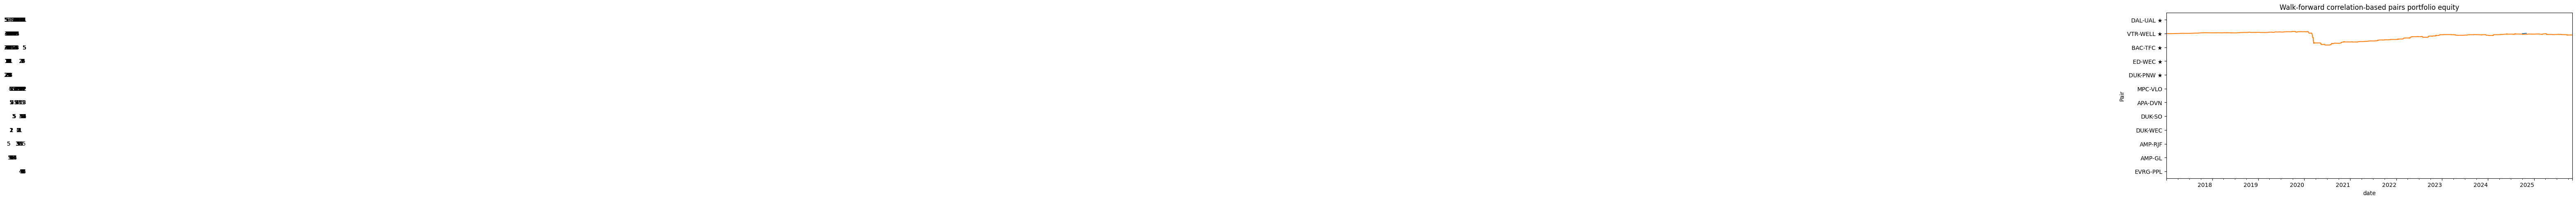

In [ ]:

import numpy as np, pandas as pd, re
from pandas.tseries.offsets import MonthEnd, DateOffset
import matplotlib.pyplot as plt

# ---------- Base matrices ----------
px  = (ohlcv.pivot(index="date", columns="ticker", values="adj_close").sort_index())
vol = (ohlcv.pivot(index="date", columns="ticker", values="volume").reindex(px.index))

meta = ohlcv.drop_duplicates("ticker")[["ticker","name","GICS Sector","GICS Sub-Industry"]].copy()

def issuer_key(name: str) -> str:
    s = (name or "").lower()
    s = re.sub(r"\(.*?\)", " ", s)
    s = re.sub(r"\b(class|cl|series)\b\s*[a-z0-9\-]*", " ", s)
    s = re.sub(r"\b(incorporated|inc|corp|corporation|company|co|plc|ltd|limited|sa|nv|ag)\b\.?", " ", s)
    s = re.sub(r"[^a-z0-9]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

meta["issuer"] = meta["name"].map(issuer_key)
issuer_map = meta.set_index("ticker")["issuer"].to_dict()

def dedup_classes_by_adv(px_f, vol_f):
    adv_f = (px_f * vol_f).mean().rename("ADV")
    m = meta.copy()
    m["ADV_form"] = m["ticker"].map(adv_f)
    keep_one = (m.dropna(subset=["ADV_form"])
                  .sort_values("ADV_form", ascending=False)
                  .drop_duplicates(subset=["issuer"]))["ticker"].tolist()
    return px_f[keep_one], vol_f[keep_one], adv_f.reindex(keep_one).fillna(0.0)

def top_k_pairs_by_corr(ret_df, k, method, issuer_map, adv_series,
                        enforce_disjoint=True, positive_only=True,
                        use_abs=False, min_obs=40):
    cols = ret_df.columns.tolist()
    cand = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            a, b = cols[i], cols[j]
            if issuer_map.get(a) == issuer_map.get(b):
                continue
            xy = ret_df[[a,b]].dropna()
            if len(xy) < min_obs:
                continue
            rho = xy.corr(method=method).iloc[0,1]
            if np.isnan(rho):
                continue
            if positive_only and rho <= 0:
                continue
            score = abs(rho) if use_abs else rho
            cand.append((a,b,rho,score,len(xy),adv_series.get(a, np.nan), adv_series.get(b, np.nan)))
    cand.sort(key=lambda x: -x[3])

    chosen, used = [], set()
    for a,b,r,_,n,adv_a,adv_b in cand:
        if enforce_disjoint and (a in used or b in used):
            continue
        chosen.append((a,b,r,n,adv_a,adv_b))
        used.add(a); used.add(b)
        if len(chosen) >= k: break

    return pd.DataFrame(chosen, columns=["ticker_A","ticker_B","corr","n_days","ADV_A","ADV_B"])

# ---------- Monthly walk-forward: trailing 12M formation, trade next month, aggregate 6 months ----------
trade_month_starts = pd.date_range("2016-12-01", "2025-10-01", freq="MS")
rows = []

for ms in trade_month_starts:
    me   = min(px.index.max(), (ms + MonthEnd(1)))
    fs   = (ms - DateOffset(months=12)).normalize()
    fe   = (ms - pd.Timedelta(days=1))

    px_f  = px.loc[(px.index>=fs) & (px.index<=fe)]
    vol_f = vol.loc[px_f.index]
    # Formation-window de-duping (per issuer keep the most liquid share class)
    px_f, vol_f, adv_f = dedup_classes_by_adv(px_f, vol_f)
    # Coverage filter
    min_obs_ratio = 0.85
    keep = [t for t in px_f.columns if px_f[t].count() >= int(min_obs_ratio*len(px_f))]
    px_f, vol_f, adv_f = px_f[keep], vol_f[keep], adv_f.reindex(keep).fillna(0.0)

    ret_f = px_f.pct_change().dropna(how="all")

    # Top-5 for both correlation methods
    for method in ("pearson","spearman", "kendall"):
        top5 = top_k_pairs_by_corr(ret_df=ret_f, k=5, method=method,
                                   issuer_map=issuer_map, adv_series=adv_f,
                                   enforce_disjoint=True, positive_only=True,
                                   use_abs=False, min_obs=40)
        if len(top5):
            top5.insert(0, "rank", range(1, len(top5)+1))
            top5.insert(0, "method", method)
            top5.insert(0, "trade_month", ms.strftime("%Y-%m"))
            top5.insert(0, "formation_window", f"{fs.date()} → {fe.date()}")
            rows.append(top5)

results = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
# Sort for readability
results = results.sort_values(["trade_month","method","rank"])
print(results.to_string(index=False))

results.to_csv("walkforward_top5_pairs.csv", index=False)

"""
Evaluates whether the Top-5 pairs selected in each formation window (past 12 months) remain correlated in the subsequent “trading” month.
While the original pipeline only ranks pairs based on in-sample correlation, this extension computes the true out-of-sample correlation
(corr_oos) and compares it with the in-sample correlation (corr_is) to measure persistence.
"""

df_oos = results.copy()

# trade_month
df_oos["tm_start"] = df_oos["trade_month"].astype(str).astype("datetime64[ns]")
df_oos["tm_end"]   = (df_oos["tm_start"] + MonthEnd(0))

oos_corr_list = []

for idx, row in df_oos.iterrows():
    a, b = row["ticker_A"], row["ticker_B"]
    start, end = row["tm_start"], row["tm_end"]

    px_sub = px.loc[(px.index >= start) & (px.index <= end), [a, b]].dropna()
    if len(px_sub) < 10:
        oos_corr = float("nan")
    else:
        ret_sub = px_sub.pct_change().dropna()
        oos_corr = ret_sub.corr(method=row["method"]).iloc[0,1]

    oos_corr_list.append(oos_corr)

df_oos["corr_oos"]  = oos_corr_list
df_oos["corr_is"]   = df_oos["corr"]
df_oos["corr_diff"] = df_oos["corr_oos"] - df_oos["corr_is"]

summary = (df_oos
           .groupby("method")[["corr_is","corr_oos","corr_diff"]]
           .mean()
           .round(3))
print(summary)

df = results.copy()
# Normalize month type and build pair key A-B (alphabetical)
df["trade_month"] = pd.PeriodIndex(df["trade_month"].astype(str), freq="M")
def pair_key(a, b):
    a = str(a).strip().upper(); b = str(b).strip().upper()
    return "-".join(sorted([a, b]))

a_col = "ticker_A" if "ticker_A" in df.columns else "ticker_a"
b_col = "ticker_B" if "ticker_B" in df.columns else "ticker_b"
df["pair"] = [pair_key(a, b) for a, b in zip(df[a_col], df[b_col])]
df = df.sort_values(["method", "trade_month", "rank"]).reset_index(drop=True)

def plot_top5_heatmap_from_results(d: pd.DataFrame, method: str,
                                   top_n_rows: int = 12, outfile: str | None = None):
    x = d[d["method"].str.lower() == method.lower()].copy()
    if x.empty:
        print(f"No data for method={method}");
        return
    months = sorted(x["trade_month"].unique())
    first_m = months[0]
    # Baseline “fixed” (approx.): Top-5 from the first trade month
    baseline = set(x[x["trade_month"] == first_m]["pair"].head(5).tolist())

    # Row order: baseline first, then by #months desc / avg rank asc
    stats = (x.groupby("pair")
               .agg(months_appeared=("trade_month","nunique"),
                    avg_rank=("rank","mean"),
                    avg_corr=("corr","mean"))
               .sort_values(["months_appeared","avg_rank"], ascending=[False, True]))
    order = [p for p in stats.index if p in baseline] + [p for p in stats.index if p not in baseline]
    order = order[:top_n_rows]

    # Rank matrix 1..5 (0 = not in Top-5)
    pivot = (x.pivot_table(index="pair", columns="trade_month", values="rank", aggfunc="min")
               .reindex(index=order, columns=months))
    M = pivot.fillna(0).to_numpy()

    # Plot (Matplotlib)
    fig, ax = plt.subplots(figsize=(1.3*len(months)+2, 0.5*len(order)+2))
    im = ax.imshow(M, aspect="auto", interpolation="nearest")

    ax.set_xticks(np.arange(len(months)))
    ax.set_xticklabels([str(m) for m in months], rotation=45, ha="right")
    ylabels = [f"{p} ★" if p in baseline else p for p in order]
    ax.set_yticks(np.arange(len(order)))
    ax.set_yticklabels(ylabels)

    # Annotate rank inside each cell
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            v = M[i, j]
            if v > 0:
                ax.text(j, i, f"{int(v)}", ha="center", va="center")

    ax.set_title(f"Monthly Walk-Forward Top-30 — {method.title()} (numbers = rank 1–30)\n"
                 f"★ rows = baseline fixed Top-5 (first month’s formation)")
    ax.set_xlabel("Trade Month")
    ax.set_ylabel("Pair")
    fig.tight_layout()

    if outfile:
        fig.savefig(outfile, dpi=160, bbox_inches="tight")
    return fig, ax

plot_top5_heatmap_from_results(df, "pearson",  top_n_rows=12, outfile="top30_heatmap_pearson.png")
# plot_top5_heatmap_from_results(df, "spearman", top_n_rows=12, outfile="top30_heatmap_spearman.png")
# plot_top5_heatmap_from_results(df, "kendall", top_n_rows=12, outfile="top30_heatmap_kendall.png")


print("str binding is:", str, " | type:", type(str))

import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset

# OLS for Beta
method_to_use = "pearson"

res = results.copy()
res = res[res["method"] == method_to_use].copy()
if res.empty:
    raise ValueError(f"No pairs found for method={method_to_use}")

res["trade_month"] = res["trade_month"].astype(str)

# Rolling return
ret_all = px.pct_change().dropna(how="all")

ols_rows = []

# OLS：r_X = alpha + beta * r_Y
def ols_xy(x_series, y_series):
    x = x_series.values.astype(float)
    y = y_series.values.astype(float)
    if len(x) < 10:
        return np.nan, np.nan, np.nan  # alpha, beta, R2

    x_mean = x.mean()
    y_mean = y.mean()

    # beta = Cov(X,Y) / Var(Y)
    cov_xy = np.mean((y - y_mean) * (x - x_mean))
    var_y  = np.mean((y - y_mean)**2)
    if var_y == 0 or np.isnan(var_y):
        return np.nan, np.nan, np.nan

    beta = cov_xy / var_y
    alpha = x_mean - beta * y_mean

    fitted = alpha + beta * y
    ss_tot = np.sum((x - x_mean)**2)
    ss_res = np.sum((x - fitted)**2)
    if ss_tot <= 0:
        R2 = np.nan
    else:
        R2 = 1.0 - ss_res / ss_tot

    return alpha, beta, R2


for tm, grp in res.groupby("trade_month"):
    ms = pd.to_datetime(tm + "-01")                 # trade month start
    fs = (ms - DateOffset(months=12)).normalize()   # formation start
    fe = ms - pd.Timedelta(days=1)                  # formation end

    # Formation period price window
    px_f = px.loc[(px.index >= fs) & (px.index <= fe)].copy()
    if px_f.empty:
        continue

    for _, row in grp.iterrows():
        X = row["ticker_A"]
        Y = row["ticker_B"]

        if X not in px_f.columns or Y not in px_f.columns:
            continue

        xy = px_f[[X, Y]].dropna()
        # xy = np.log(px_f[[X, Y]]).dropna()
        if len(xy) < 40:
            continue

        alpha, beta, R2 = ols_xy(xy[X], xy[Y])

        if np.isnan(R2) or R2 < 0.6:
            continue

        ols_rows.append({
            "trade_month": tm,
            "method": method_to_use,
            "X": X,
            "Y": Y,
            "alpha": alpha,
            "beta": beta,
            "R2": R2,
            "n_obs": len(xy),
            "formation_start": fs,
            "formation_end": fe,
            "corr_rank": row["rank"],
            "corr_in_formation": row["corr"], # Return corr
        })

ols_df = (pd.DataFrame(ols_rows)
          .sort_values(["trade_month", "R2"], ascending=[True, False])
          .reset_index(drop=True))

print("Per-month OLS on RETURNS (R^2 >= 0.6) results:")
display(ols_df.head(20))
print(f"Total kept pairs (all months): {len(ols_df)}")

# ==========================================================
# Display example month
# ==========================================================
trade_month_for_backtest = "2020-06"

coint_df = (
    ols_df[ols_df["trade_month"] == trade_month_for_backtest]
      .sort_values("R2", ascending=False)
      .head(30)
      .reset_index(drop=True)
)

print(f"Pairs for backtest month = {trade_month_for_backtest}:")
display(coint_df[["X","Y","alpha","beta","R2","n_obs","corr_in_formation"]])

from pandas.tseries.offsets import DateOffset, MonthEnd
# Backtest base function
def backtest_one_pair_single_month(
    ret_all: pd.DataFrame,
    X: str,
    Y: str,
    beta: float,
    trade_month: str,
    formation_months: int = 12,
    z_window: int = 60,
    entry_z: float = 2.0,
    exit_z: float = 0.5,
    stop_z: float = 3.0,
    tc_bps: float = 20.0
):
    # Time horizon
    ms = pd.to_datetime(trade_month + "-01")
    formation_start = (ms - DateOffset(months=formation_months)).normalize()
    formation_end   = ms - pd.Timedelta(days=1)
    trade_start     = ms
    trade_end       = ms + MonthEnd(1)

    cols = [X, Y]

    # formation + trade's return
    ret_form = ret_all.loc[(ret_all.index >= formation_start) &
                           (ret_all.index <= formation_end), cols]
    ret_trade = ret_all.loc[(ret_all.index >= trade_start) &
                            (ret_all.index <= trade_end), cols]

    if ret_form.empty or ret_trade.empty:
        return None, None, None, None  # equity, strategy_ret, position, z_trade

    ret_full = pd.concat([ret_form, ret_trade], axis=0).sort_index().dropna(how="any")
    if ret_full.empty:
        return None, None, None, None

    # spread_ret
    spread_full = ret_full[X] - beta * ret_full[Y]

    # rolling z-score
    m = spread_full.rolling(z_window).mean()
    s = spread_full.rolling(z_window).std()
    z_full = (spread_full - m) / s

    # trade month z
    z_trade = z_full.loc[(z_full.index >= trade_start) &
                         (z_full.index <= trade_end)]

    if z_trade.empty:
        return None, None, None, None

    # position (signal time)
    position = pd.Series(0, index=z_trade.index)
    state = 0  # 0=flat, 1=long spread, -1=short spread

    for t, z_t in z_trade.items():
        if np.isnan(z_t):
            position.loc[t] = state
            continue

        if state == 0:
            if z_t > entry_z:
                state = -1  # short spread
            elif z_t < -entry_z:
                state = 1   # long spread
        else:
            if -exit_z < z_t < exit_z:
                state = 0
            elif abs(z_t) >= stop_z:
                state = 0
        position.loc[t] = state

    # avoid info leakage
    position = position.shift(1).fillna(0)

    # calculate return
    ret_trade_clip = ret_all.loc[(ret_all.index >= trade_start) &
                                 (ret_all.index <= trade_end), cols]
    if ret_trade_clip.empty:
        return None, None, None, None

    spread_ret_trade = (ret_trade_clip[X] - beta * ret_trade_clip[Y]).reindex(position.index).fillna(0.0)

    # Gross return
    gross_ret = position * spread_ret_trade

    # trading cost
    # tc_bps
    tc_rate = tc_bps / 10000.0

    # Position change：Today - yesterday (position is already lagged)
    pos_change = position.diff().abs().fillna(0.0)

    # Cost = |Δposition| * One way cost
    tc_cost = pos_change * tc_rate

    # After deduction
    strategy_ret = gross_ret - tc_cost
    # =======================

    if strategy_ret.replace(0, np.nan).count() == 0:
        # Non holding
        return None, None, position, z_trade

    equity = (1 + strategy_ret).cumprod()
    if len(equity) > 0:
        equity.iloc[0] = 1.0

    return equity, strategy_ret, position, z_trade

# Portfolio backtest one month
def backtest_portfolio_one_month(
    ols_df: pd.DataFrame,
    ret_all: pd.DataFrame,
    trade_month: str,
    formation_months: int = 12,
    z_window: int = 30,
    entry_z: float = 2.0,
    exit_z: float = 2.0,
    tc_bps: float = 20.0
):
    rows = ols_df[ols_df["trade_month"] == trade_month]
    if rows.empty:
        print(f"No pairs for trade_month = {trade_month}")
        return None, None, None

    pair_rets = {}
    for _, r in rows.iterrows():
        X = r["X"]
        Y = r["Y"]
        beta = r["beta"]

        eq, strat_ret, pos, z_t = backtest_one_pair_single_month(
            ret_all=ret_all,
            X=X,
            Y=Y,
            beta=beta,
            trade_month=trade_month,
            formation_months=formation_months,
            z_window=z_window,
            entry_z=entry_z,
            exit_z=exit_z,
            tc_bps=tc_bps
        )

        # If no trade then skip
        if strat_ret is None or strat_ret.replace(0, np.nan).count() == 0:
            continue

        pair_name = f"{X}-{Y}"
        pair_rets[pair_name] = strat_ret

    if not pair_rets:
        print(f"No active trades for trade_month = {trade_month}")
        return None, None, None

    # Align pairs daily return
    pair_rets_df = pd.DataFrame(pair_rets).sort_index()

    # equal-weight portfolio
    portfolio_ret = pair_rets_df.mean(axis=1)

    portfolio_equity = (1 + portfolio_ret).cumprod()
    if len(portfolio_equity) > 0:
        portfolio_equity.iloc[0] = 1.0

    return portfolio_equity, portfolio_ret, pair_rets_df

# Example month display
tm = "2024-10"

port_eq, port_ret, pair_rets_df = backtest_portfolio_one_month(
    ols_df=ols_df,
    ret_all=ret_all,
    trade_month=tm,
    formation_months=12,
    z_window=20,
    entry_z=2.0,
    exit_z=0.5
)

if port_eq is not None:
    print(f"{tm} Length: {len(port_ret)}, # of pair: {pair_rets_df.shape[1]}")
    ax = port_eq.plot(title=f"Portfolio equity ({tm}) - equal weight across pairs")
else:
    print("No equity for this month.")

# OLS Results
trade_months = sorted(ols_df["trade_month"].unique())
print("trade_months:", trade_months)

all_port_rets = []

# All months
for tm in trade_months:
    port_eq, port_ret, pair_rets_df = backtest_portfolio_one_month(
        ols_df=ols_df,
        ret_all=ret_all,
        trade_month=tm,
        formation_months=12,
        z_window=30,
        entry_z=2.0,
        exit_z=0.5,
        tc_bps= 20.0
    )

    if port_ret is None:
        print(f"[{tm}] no active trades, skip.")
        continue
    port_ret.name = tm
    all_port_rets.append(port_ret)

# Combine all months return
if not all_port_rets:
    print("No monthly portfolio returns at all.")
else:
    combined_ret = pd.concat(all_port_rets).sort_index()

    print("Days:", len(combined_ret))
    print("Start->End:", combined_ret.index.min(), "→", combined_ret.index.max())

    # Equity curve
    total_equity = (1 + combined_ret).cumprod()
    if len(total_equity) > 0:
        total_equity.iloc[0] = 1.0

    ax = total_equity.plot(
        figsize=(10, 5),
        title="Walk-forward correlation-based pairs portfolio equity"
    )



#### 10 Years Rolling

trade_months: ['2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-

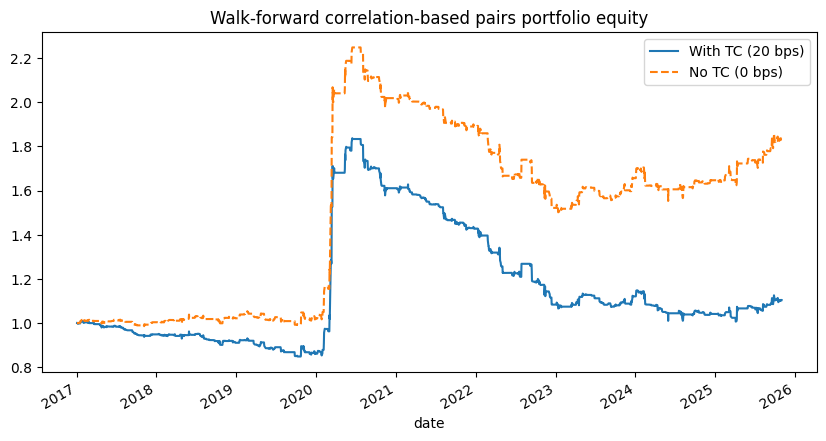

In [ ]:
# OLS Results
trade_months = sorted(ols_df["trade_month"].unique())
print("trade_months:", trade_months)

rets_tc20 = []
rets_tc0  = []

for tm in trade_months:

    # With trading cost
    port_eq, port_ret, pair_rets_df = backtest_portfolio_one_month(
        ols_df=ols_df,
        ret_all=ret_all,
        trade_month=tm,
        formation_months=12,
        z_window=30,
        entry_z=2.0,
        exit_z=0.5,
        tc_bps=20.0
    )

    if port_ret is not None:
        port_ret.name = tm
        rets_tc20.append(port_ret)
    else:
        print(f"[{tm}] tc20 version: no trades")

    # No trading cost
    port_eq0, port_ret0, pair_rets_df0 = backtest_portfolio_one_month(
        ols_df=ols_df,
        ret_all=ret_all,
        trade_month=tm,
        formation_months=12,
        z_window=30,
        entry_z=2.0,
        exit_z=0.5,
        tc_bps=0.0
    )

    if port_ret0 is not None:
        port_ret0.name = tm
        rets_tc0.append(port_ret0)
    else:
        print(f"[{tm}] tc0 version: no trades")

# ---- Combine returns for both curves ----
if not rets_tc20:
    print("No monthly returns for tc20.")
else:
    combined_tc20 = pd.concat(rets_tc20).sort_index()
    combined_tc0  = pd.concat(rets_tc0 ).sort_index()

    eq_tc20 = (1 + combined_tc20).cumprod()
    eq_tc0  = (1 + combined_tc0 ).cumprod()

    eq_tc20.iloc[0] = 1.0
    eq_tc0.iloc[0]  = 1.0

    # ---- Plot both lines ----
    ax = eq_tc20.plot(figsize=(10,5), label="With TC (20 bps)")
    eq_tc0.plot(ax=ax, label="No TC (0 bps)", linestyle="--")

    ax.set_title("Walk-forward correlation-based pairs portfolio equity")
    ax.legend()
result_corr_roll_10 = eq_tc20.copy()

#### 1 Year Rolling

trade_months: ['2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08', '2025-09', '2025-10']


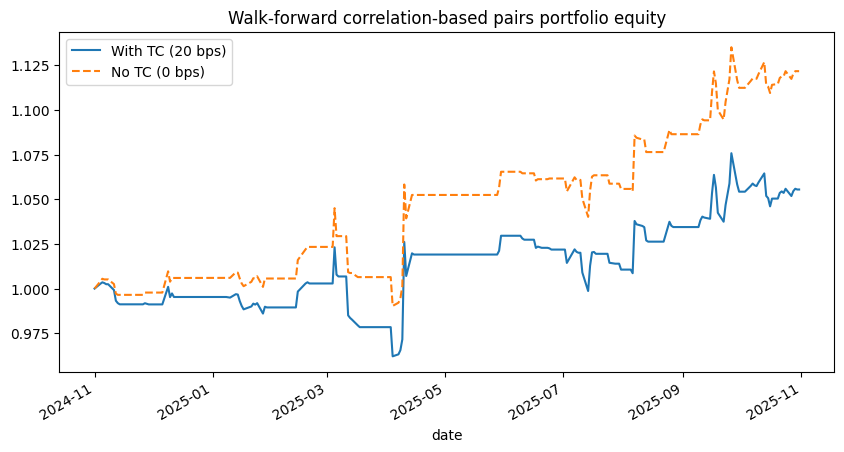

In [ ]:
# OLS Results
trade_months = ['2024-11','2024-12','2025-01','2025-02','2025-03','2025-04','2025-05','2025-06','2025-07','2025-08','2025-09','2025-10']
print("trade_months:", trade_months)

all_port_rets = []

rets_tc20 = []
rets_tc0  = []

for tm in trade_months:

    # With trading cost
    port_eq, port_ret, pair_rets_df = backtest_portfolio_one_month(
        ols_df=ols_df,
        ret_all=ret_all,
        trade_month=tm,
        formation_months=12,
        z_window=30,
        entry_z=2.0,
        exit_z=0.5,
        tc_bps=20.0
    )

    if port_ret is not None:
        port_ret.name = tm
        rets_tc20.append(port_ret)
    else:
        print(f"[{tm}] tc20 version: no trades")

    # No trading cost
    port_eq0, port_ret0, pair_rets_df0 = backtest_portfolio_one_month(
        ols_df=ols_df,
        ret_all=ret_all,
        trade_month=tm,
        formation_months=12,
        z_window=30,
        entry_z=2.0,
        exit_z=0.5,
        tc_bps=0.0
    )

    if port_ret0 is not None:
        port_ret0.name = tm
        rets_tc0.append(port_ret0)
    else:
        print(f"[{tm}] tc0 version: no trades")

# ---- Combine returns for both curves ----
if not rets_tc20:
    print("No monthly returns for tc20.")
else:
    combined_tc20 = pd.concat(rets_tc20).sort_index()
    combined_tc0  = pd.concat(rets_tc0 ).sort_index()

    eq_tc20 = (1 + combined_tc20).cumprod()
    eq_tc0  = (1 + combined_tc0 ).cumprod()

    eq_tc20.iloc[0] = 1.0
    eq_tc0.iloc[0]  = 1.0

    # ---- Plot both lines ----
    ax = eq_tc20.plot(figsize=(10,5), label="With TC (20 bps)")
    eq_tc0.plot(ax=ax, label="No TC (0 bps)", linestyle="--")

    ax.set_title("Walk-forward correlation-based pairs portfolio equity")
    ax.legend()

## Combined Analysis

In [ ]:
# All results

# Correlation fixed and rolling
result_corr_fixed_06
result_corr_roll_10
# Cointegration fixed and rolling
result_coin_fixed_06
result_coin_roll_10
# Distance fixed and rolling
result_dis_roll_10
result_dis_fixed_06

date
2025-05-12    1.000000
2025-05-13    0.994700
2025-05-14    1.000211
2025-05-15    0.999145
2025-05-16    0.994344
                ...   
2025-11-06    1.056379
2025-11-07    1.048706
2025-11-10    1.048416
2025-11-11    1.047979
2025-11-12    1.048639
Length: 129, dtype: float64

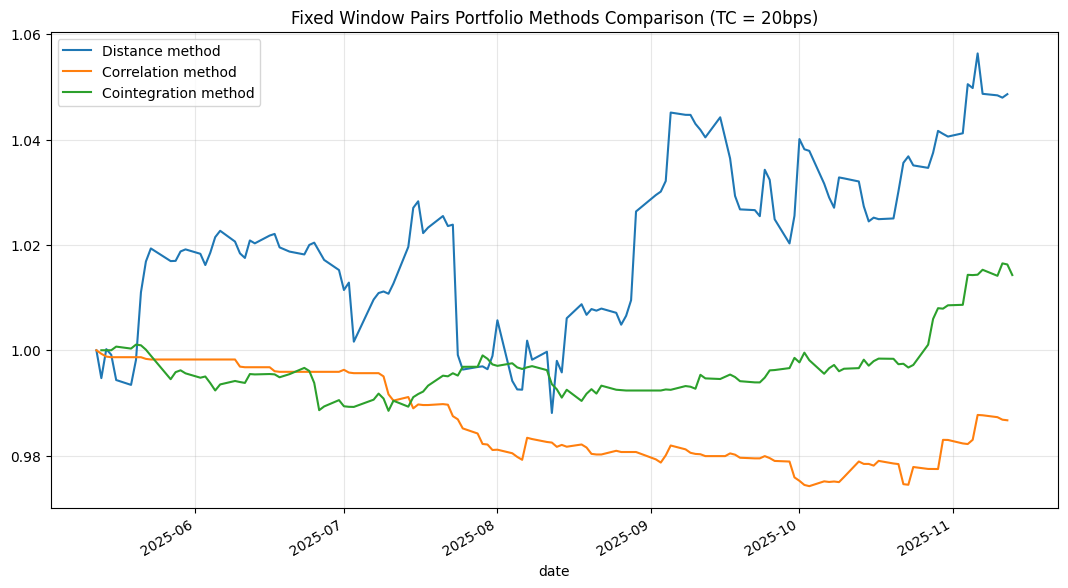

In [ ]:

# Print results half-year for fixed window
ax = result_dis_fixed_06.plot(figsize=(13,7), label="Distance method")
result_corr_fixed_06.plot(ax=ax, label="Correlation method")
result_coin_fixed_06.plot(ax=ax, label="Cointegration method")

ax.set_title("Fixed Window Pairs Portfolio Methods Comparison (TC = 20bps)")
ax.legend()
ax.legend(framealpha=0.8)
ax.grid(alpha=0.3)

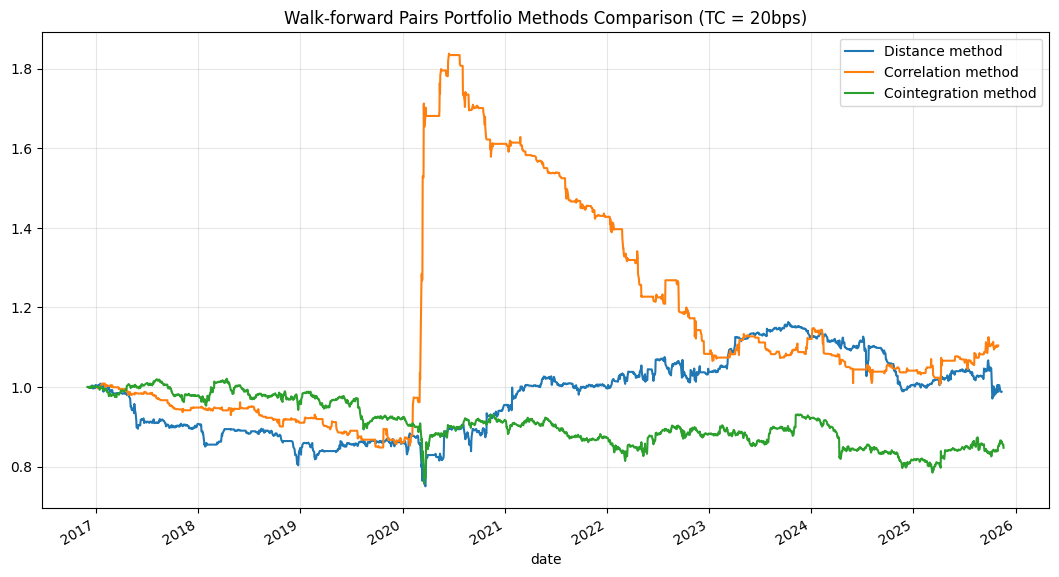

In [ ]:
# Print results 10-year for Rolling window
ax = result_dis_roll_10.plot(figsize=(13,7), label="Distance method")
result_corr_roll_10.plot(ax=ax, label="Correlation method")
result_coin_roll_10.plot(ax=ax, label="Cointegration method")

ax.set_title("Walk-forward Pairs Portfolio Methods Comparison (TC = 20bps)")
ax.legend()
ax.legend(framealpha=0.8)
ax.grid(alpha=0.3)